<a href="https://colab.research.google.com/github/fiapdatanalytics/tech-challenge4/blob/main/tech_challenge_4_data_viz_and_production_models_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge 4 - Data viz and production models**

## **Desafio**

🎯 Objetivo do Projeto

Desenvolver um modelo preditivo de Machine Learning para auxiliar uma equipe médica a diagnosticar níveis de obesidade em pacientes, com assertividade mínima de 75%, deployado em uma aplicação Streamlit, acompanhado de dashboard analítico e vídeo de apresentação.

🧩 Entregáveis Principais

* Pipeline de Machine Learning
* Feature engineering, treinamento e avaliação do modelo.
* Modelo com acurácia ≥ 75%
* Deploy no Streamlit
* Aplicação funcional acessível por link público.
* Dashboard analítico
* Visualização dos principais insights.
* Documentação (.doc ou .txt)
* Links do app, dashboard e repositório GitHub.
* Vídeo de apresentação (4 a 10 minutos)


# **Bibliotecas**

In [301]:
import pandas as pd
import re
import json
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy.stats import chisquare
import scipy.stats as stats
from typing import List, Optional # Importa os tipos necessários
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder






# **Funções**

## **Dicionario dados**

In [302]:
def criar_novo_dicionario_dados(df: pd.DataFrame) -> dict:
    """
    Cria um novo dicionário de dados com uma estrutura inicial para cada coluna do DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão usadas para criar o dicionário.

    Returns:
        dict: O novo dicionário de dados.
    """
    try:
        novo_dicionario = {}
        for coluna in df.columns:
            novo_dicionario[coluna] = {
                'nome_original': coluna,
                'tipo_coluna': 'original',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {}
            }
        print("Novo dicionário de dados criado.")
        return novo_dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao criar o novo dicionário de dados: {e}")
        return None

### **Atualiza de forma manual das colunas do dicionario de dados**

In [303]:
def atualizar_campo_dicionario(dicionario: dict, coluna: str, campo: str, novo_valor):
    """
    Atualiza um campo específico para uma coluna no dicionário de dados.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna (str): O nome da coluna (chave no dicionário) cujo campo será atualizado.
        campo (str): O nome do campo a ser atualizado ('nome_original', 'novo_nome', 'descricao', 'transformacao').
        novo_valor: O novo valor para o campo especificado.
    """
    try:
        if coluna in dicionario:
            if campo == 'nome_original':
                print(f"Erro: Não é permitido atualizar o campo 'nome_original'.")
            elif campo in dicionario[coluna]:
                 if campo == 'transformacao' and isinstance(novo_valor, dict):
                      if not isinstance(dicionario[coluna][campo], dict):
                           print(f"Aviso: O campo 'transformacao' para a coluna '{coluna}' não é um dicionário. Inicializando como dicionário vazio.")
                           dicionario[coluna][campo] = {}
                      dicionario[coluna][campo].update(novo_valor)
                      print(f"Campo '{campo}' da coluna '{coluna}' atualizado com novos itens.")
                 else:
                     dicionario[coluna][campo] = novo_valor
                     print(f"Campo '{campo}' da coluna '{coluna}' atualizado para: '{novo_valor}'")
            else:
                print(f"Erro: O campo '{campo}' não existe para a coluna '{coluna}' no dicionário de dados.")
        else:
            print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o campo '{campo}' para a coluna '{coluna}': {e}")

### **Atualiza nomes dicionario**

In [304]:
def atualizar_dicionario_renomeacao(dicionario: dict, mapa_colunas: dict):
    """
    Atualiza o dicionário de dados com base nas renomeações de colunas aplicadas.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        mapa_colunas (dict): Dicionário com o mapeamento de renomeação de colunas (nome_original: novo_nome).
    """
    try:
        print("Iniciando a atualização do dicionário de dados com renomeações...")

        chaves_originais = list(dicionario.keys())

        for chave_original in chaves_originais:
            if chave_original in dicionario:
                info = dicionario[chave_original]
                nome_original = info.get('nome_original')
                novo_nome_existente = info.get('novo_nome')


                if nome_original in mapa_colunas:
                    atualiza_novo_nome = mapa_colunas[nome_original]

                    if chave_original != atualiza_novo_nome and (novo_nome_existente is None or novo_nome_existente != atualiza_novo_nome):

                         dicionario[atualiza_novo_nome] = dicionario.pop(chave_original)
                         info = dicionario[atualiza_novo_nome] #


                    info['novo_nome'] = atualiza_novo_nome



                    if not isinstance(info.get('transformacao'), dict):
                        info['transformacao'] = {}

                    renome_desc = f"Renomeada de '{nome_original}' para '{atualiza_novo_nome}'."
                    if renome_desc not in info['transformacao'].values():
                         transform_key = f"transformacao_{len(info['transformacao']) + 1}"
                         info['transformacao'][transform_key] = renome_desc

                elif novo_nome_existente is not None and chave_original != novo_nome_existente:

                     if novo_nome_existente in dicionario:

                          print(f"Aviso: Conflito ao renomear. '{chave_original}' tem novo_nome '{novo_nome_existente}', mas '{novo_nome_existente}' já existe no dicionário.")
                     else:
                          dicionario[novo_nome_existente] = dicionario.pop(chave_original)
                          info = dicionario[novo_nome_existente]


        print("Dicionário de dados atualizado com renomeações.")

    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com renomeações: {e}")


### **Atualiza Dicionario com as novas colunas criadas**

In [305]:
def atualizar_dicionario_novas_colunas(dicionario: dict, df: pd.DataFrame):
    """
    Atualiza o dicionário de dados com informações sobre colunas recém-criadas no DataFrame.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas recém-criadas.
    """
    print("Iniciando a atualização do dicionário de dados com novas colunas...")
    try:
        colunas_atuais = df.columns.tolist()

        existing_keys_and_new_names = set()
        for key, info in dicionario.items():
            existing_keys_and_new_names.add(key)
            if info.get('novo_nome'):
                existing_keys_and_new_names.add(info['novo_nome'])


        novas_colunas = [col for col in colunas_atuais if col not in existing_keys_and_new_names]

        for nova_coluna in novas_colunas:

            dicionario[nova_coluna] = {
                'nome_original': nova_coluna,
                'tipo_coluna' : 'criada',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {}
            }
            print(f"Adicionada nova coluna '{nova_coluna}' ao dicionário de dados.")


        print("Dicionário de dados atualizado com novas colunas.")
        return dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário com novas colunas: {e}")
        return None

### **Atualiza campo descricao do dicionario em lote**

In [306]:
def atualizar_descricoes_dicionario(dicionario: dict, descricoes: dict):
    """
    Atualiza o campo 'descricao' no dicionário de dados com base em um dicionário de descrições.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        descricoes (dict): O dicionário contendo as descrições (chave: nome da coluna, valor: descrição).

    Returns:
        int: A quantidade de descrições atualizadas.
    """
    quantidade_linhas_atualizadas = 0
    try:

        if not isinstance(descricoes, dict):
            print("Erro: O argumento 'descricoes' deve ser um dicionário.")
            return 0

        for chave in dicionario:
            if chave in descricoes:

                atualizar_campo_dicionario(dicionario, chave, 'descricao', descricoes[chave])
                quantidade_linhas_atualizadas += 1

        print(f'Quantidade de descrições atualizadas: {quantidade_linhas_atualizadas}.')
        return quantidade_linhas_atualizadas
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar as descrições no dicionário: {e}")
        return 0




### **Atualiza Transformação one hot encoding**

In [307]:
def atualizar_dicionario_ohe(dicionario: dict, df: pd.DataFrame, coluna_original: str) -> None:
    """
    ohe = one hot encoding
    Atualiza o dicionário de dados com informações sobre colunas criadas por One-Hot Encoding.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas One-Hot Encoded.
        coluna_original (str): O nome da coluna original que foi transformada (e também o prefixo usado para as novas colunas).
    """
    print(f"Iniciando a atualização do dicionário de dados para colunas OHE da variável '{coluna_original}'...")
    try:

        atualizar_dicionario_novas_colunas(dicionario, df)

        novas_colunas_ohe = [col for col in df.columns if col.startswith(f'{coluna_original}_')]

        info_coluna_original = dicionario.get(coluna_original, {})

        for coluna_ohe in novas_colunas_ohe:
            if coluna_ohe in dicionario:

                dicionario[coluna_ohe]['nome_original'] = coluna_original
                dicionario[coluna_ohe]['novo_nome'] = coluna_ohe
                dicionario[coluna_ohe]['tipo_coluna'] = 'criada_ohe'


                categoria = coluna_ohe.replace(f'{coluna_original}_', '')
                if info_coluna_original and info_coluna_original.get('descricao'):
                     dicionario[coluna_ohe]['descricao'] = f"Representa a categoria '{categoria}' da variável original '{coluna_original}'. Descrição original: {info_coluna_original['descricao']}"
                else:
                    dicionario[coluna_ohe]['descricao'] = f"Variável dummy para a categoria '{categoria}' da coluna original '{coluna_original}'."



                if 'transformacao' not in dicionario[coluna_ohe] or not isinstance(dicionario[coluna_ohe]['transformacao'], dict):
                    dicionario[coluna_ohe]['transformacao'] = {}

                transform_key_number = len(dicionario[coluna_ohe]['transformacao']) + 1
                transformacao_info = {
                    f'transformacao_{transform_key_number}': f"Criada via One-Hot Encoding da coluna '{coluna_original}' (representa a categoria '{categoria}')"
                }
                atualizar_campo_dicionario(dicionario, coluna_ohe, 'transformacao', transformacao_info)
            else:
                print(f"Aviso: Coluna '{coluna_ohe}' não encontrada no dicionário de dados após adicionar novas colunas.")

        # Opcional: Remover a entrada da coluna original se ela foi completamente substituída
        # if coluna_original in dicionario and all(col not in df.columns for col in dicionario[coluna_original]):
        #     print(f"Removendo entrada da coluna original '{coluna_original}' do dicionário.")
        #     del dicionario[coluna_original]


        print(f"Dicionário de dados atualizado para colunas OHE da variável '{coluna_original}'.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com informações de OHE para a variável '{coluna_original}': {e}")

### **Atualiza dicionario alteracao ordinalEncoder**

In [308]:
def atualizar_dicionario_ordinal_encoding(dicionario: dict, coluna_processada: str, coluna_original: str, mapa_encoding: dict) -> None:
    """
    Atualiza o dicionário de dados com informações sobre uma coluna processada por Ordinal Encoding.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna_processada (str): O nome da coluna no DataFrame após o Ordinal Encoding.
        coluna_original (str): O nome da coluna original antes do Ordinal Encoding.
        mapa_encoding (dict): O dicionário de mapeamento usado pelo OrdinalEncoder (valor original: valor codificado).
    """
    print(f"Iniciando a atualização do dicionário de dados para a coluna '{coluna_processada}' (Ordinal Encoding)...")
    try:

        if coluna_processada not in dicionario:

            dicionario[coluna_processada] = {
                'nome_original': coluna_original,
                'tipo_coluna': 'criada_encoded_ordinal',
                'novo_nome': coluna_processada,
                'descricao': f"Coluna codificada numericamente via Ordinal Encoding da coluna original '{coluna_original}'.",
                'transformacao': {}
            }
            print(f"Adicionada nova entrada para a coluna '{coluna_processada}' ao dicionário.")
        else:

            dicionario[coluna_processada]['nome_original'] = coluna_original
            if dicionario[coluna_processada].get('tipo_coluna') != 'criada_encoded_ordinal':
                 dicionario[coluna_processada]['tipo_coluna'] = 'transformada_encoded_ordinal' # Tipo se a coluna original foi transformada

            if dicionario[coluna_processada].get('descricao') is None:
                 dicionario[coluna_processada]['descricao'] = f"Coluna codificada numericamente via Ordinal Encoding da coluna original '{coluna_original}'."



        if 'transformacao' not in dicionario[coluna_processada] or not isinstance(dicionario[coluna_processada]['transformacao'], dict):
            dicionario[coluna_processada]['transformacao'] = {}

        transform_key_number = len(dicionario[coluna_processada]['transformacao']) + 1
        transformacion_info = {
            f'transformacao_{transform_key_number}': "Aplicado Ordinal Encoding",
            "tipo": "ordinal_encoding",
            "mapa_aplicado": mapa_encoding
        }

        atualizar_campo_dicionario(dicionario, coluna_processada, 'transformacao', transformacion_info)


        print(f"Dicionário de dados atualizado para a coluna '{coluna_processada}'.")

    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com informações de Ordinal Encoding para a coluna '{coluna_processada}': {e}")

## **Funções estatísticas**

### **Análise bi-variada para variável categórica**

In [309]:
def analisar_variavel_categorica_bi_variada(
    df: pd.DataFrame,
    coluna_feature: str,
    coluna_alvo: str,
    ordem_linhas: Optional[List[str]] = None,
    ordem_colunas: Optional[List[str]] = None
) -> None:
    """
    Realiza a análise bivariada completa para uma feature categórica
    em relação a uma variável alvo categórica.

    A função irá:
    1. Executar e interpretar o Teste Qui-Quadrado de Independência.
    2. Plotar um Gráfico de Barras Empilhado 100% da feature vs. alvo.

    Argumentos:
    df (pd.DataFrame): O DataFrame completo.
    coluna_feature (str): O nome da coluna da feature (eixo X, ex: 'genero').
    coluna_alvo (str): O nome da coluna alvo (legendas, ex: 'classficacao_peso_corporal').
    ordem_linhas (Optional[List[str]]): Lista opcional para forçar uma ordem
                                         específica nas barras do eixo X
                                         (ex: ['Baixo', 'Medio', 'Alto']).
    ordem_colunas (Optional[List[str]]): Lista opcional para forçar uma ordem
                                          específica nas categorias da legenda
                                          (ex: ['peso_insuficiente', 'peso_normal', ...]).
    """

    print(f"--- Análise da Feature: '{coluna_feature}' vs. Alvo: '{coluna_alvo}' ---")
    print("\n")

    try:
        # --- 0. Validação de Colunas ---
        if coluna_feature not in df.columns:
            raise KeyError(f"Coluna da feature '{coluna_feature}' não encontrada no DataFrame.")
        if coluna_alvo not in df.columns:
            raise KeyError(f"Coluna alvo '{coluna_alvo}' não encontrada no DataFrame.")

        # --- 1. Teste Qui-Quadrado (sobre dados originais) ---

        # Cria a tabela de contingência (contagens)
        crosstab_contagem = pd.crosstab(df[coluna_feature], df[coluna_alvo])

        print("--- 1. Resultados do Teste Qui-Quadrado ---")
        # Bloco try-except específico para o teste estatístico
        try:
            chi2_stat, p_value, dof, expected_freqs = stats.chi2_contingency(crosstab_contagem)

            print(f"Estatística Qui-Quadrado (χ²): {chi2_stat:.4f}")
            print(f"P-valor (p-value): {p_value:.4g}")
            print(f"Graus de Liberdade (dof): {dof}")
            print("\n")

            # Interpretação do p-valor
            alpha = 0.05
            if p_value < alpha:
                print(f"Interpretação (p < {alpha}): REJEITA H0.")
                print("CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.")
            else:
                print(f"Interpretação (p >= {alpha}): FALHA EM REJEITAR H0.")
                print("CONCLUSÃO: NÃO há evidência de associação estatística entre as variáveis.")

        except ValueError as chi_err:
            print(f"AVISO: Não foi possível calcular o Teste Qui-Quadrado: {chi_err}")
            print("Isso pode ocorrer se alguma categoria tiver contagens esperadas nulas.")

        print("\n" + "="*80 + "\n")

        # --- 2. Preparação para o Gráfico (com ordenação) ---

        print("--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---")

        # Normaliza a tabela de contagens para proporções (linhas somam 100%)
        crosstab_pct = crosstab_contagem.apply(lambda r: r / r.sum(), axis=1)

        # Cria cópia para plotagem, aplicando ordenação se fornecida
        crosstab_plot = crosstab_pct.copy()

        if ordem_linhas:
            # Filtra a ordem para garantir que só existam linhas presentes no índice
            linhas_validas = [l for l in ordem_linhas if l in crosstab_plot.index]
            linhas_restantes = [l for l in crosstab_plot.index if l not in linhas_validas]
            # Reordena o índice (eixo X)
            crosstab_plot = crosstab_plot.reindex(index=linhas_validas + linhas_restantes)
            print(f"Ordenação de linhas (eixo X) aplicada: {linhas_validas + linhas_restantes}")

        if ordem_colunas:
            # Filtra a ordem para garantir que só existam colunas presentes
            colunas_validas = [c for c in ordem_colunas if c in crosstab_plot.columns]
            colunas_restantes = [c for c in crosstab_plot.columns if c not in colunas_validas]
            # Reordena as colunas (legenda/empilhamento)
            crosstab_plot = crosstab_plot[colunas_validas + colunas_restantes]
            print(f"Ordenação de colunas (legenda) aplicada: {colunas_validas + colunas_restantes}")

        #Display crosstab de porcentagem
        print('\n')
        display(round(crosstab_plot * 100,2))
        print('\n')

        # --- 3. Plotagem ---

        # Define uma paleta de cores
        num_cores = len(crosstab_plot.columns)
        colors = sns.color_palette("tab20", n_colors=num_cores)

        # Plota o gráfico
        ax = crosstab_plot.plot(
            kind='bar',
            stacked=True,
            figsize=(12, 8),
            color=colors
        )

        # --- 4. Melhorias e Anotações no Gráfico ---

        for c in ax.containers:
            labels = [f'{v*100:.1f}%' if (v > 0.01) else '' for v in c.datavalues]
            ax.bar_label(c,
                         labels=labels,
                         label_type='center',
                         color='white',
                         fontsize=9,
                         fontweight='bold')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(0, 1)

        ax.set_title(f"Distribuição de '{coluna_alvo}' por '{coluna_feature}'", fontsize=16, pad=20)
        ax.set_xlabel(coluna_feature, fontsize=12)
        ax.set_ylabel(f"Proporção de '{coluna_alvo}'", fontsize=12)

        plt.xticks(rotation=0)

        ax.legend(title=coluna_alvo, bbox_to_anchor=(1.02, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    except KeyError as ke:
        print(f"ERRO DE CHAVE: {ke}. Verifique se os nomes das colunas estão corretos.")
    except Exception as e:
        print(f"ERRO INESPERADO ao analisar '{coluna_feature}': {e}")

### **Função qui-quadrado**

In [310]:
def realizar_teste_qui_quadrado(frequencias_observadas, f_esperadas=None, alpha=0.05):
    """
    Realiza o teste de Qui-Quadrado (Goodness-of-Fit ou Independência).

    Args:
        frequencias_observadas (array-like): As frequências observadas.
        f_esperadas (array-like, optional): As frequências esperadas.
                                           Se None, o teste é de aderência a uma distribuição uniforme.
        alpha (float, optional): O nível de significância para a interpretação. Padrão é 0.05.

    Returns:
        tuple: Uma tupla contendo a estatística Qui-Quadrado e o valor-p.
    """
    try:
        estatistica_qui2, valor_p = chisquare(f_obs=frequencias_observadas, f_exp=f_esperadas)

        # 4. Interpretação do resultado
        print("\n--- Interpretação ---")
        print(f"Estatística Qui-Quadrado (χ²): {estatistica_qui2:.4f}")
        print(f"Valor-p (p-value): {valor_p:.4f}")

        if valor_p <= alpha:
            print(f"Como p ({valor_p:.4f}) <= {alpha}, rejeitamos a Hipótese Nula (H0).")
            print("Conclusão: A distribuição NÃO é estatisticamente balanceada.")
        else:
            print(f"Como p ({valor_p:.4f}) > {alpha}, não podemos rejeitar a Hipótese Nula (H0).")
            print("Conclusão: A distribuição PODE ser considerada estatisticamente balanceada.")

        return estatistica_qui2, valor_p
    except ValueError as e:
        print(f"Erro nos dados de entrada: {e}")
        return None, None
    except Exception as e:
        print(f"Ocorreu um erro ao realizar o teste de Qui-Quadrado: {e}")
        return None, None

### **Razão de balanceamento**

In [311]:
def calcular_razao_desbalanceamento(quantidade_maxima: int, quantidade_minima: int) -> float:
    """
    Calcula a Razão de Desbalanceamento (Imbalance Ratio - IR) e fornece uma interpretação.

    Args:
        quantidade_maxima (int): A quantidade de ocorrências da classe majoritária.
        quantidade_minima (int): A quantidade de ocorrências da classe minoritária.

    Returns:
        float: A Razão de Desbalanceamento. Retorna float('inf') se quantidade_minima for zero.
    """
    if quantidade_minima <= 0:
        print("Erro: A quantidade mínima de ocorrências deve ser maior que zero para calcular a Razão de Desbalanceamento.")
        razao_desbalanceamento = float('inf')
    else:
        razao_desbalanceamento = quantidade_maxima / quantidade_minima

    print(f"\n--- Razão de Desbalanceamento (IR) ---")
    print(f"Quantidade da classe majoritária: {quantidade_maxima}")
    print(f"Quantidade da classe minoritária: {quantidade_minima}")
    print(f"Razão de Desbalanceamento (IR): {razao_desbalanceamento:.2f}")

    print("\n--- Interpretação da Razão de Desbalanceamento ---")


    if razao_desbalanceamento <= 2:
        print(f"🟢 Balanceado. Não faça nada.")
    elif 3 <= razao_desbalanceamento <= 10:
        print(f"🟡 Moderado. Fique atento, use F1-Score, talvez precise de class_weight.")
    elif razao_desbalanceamento > 10:
        print(f"🔴 Severo. Precisa de técnicas de balanceamento (ex: SMOTE).")
    else:
         #  casos 2 < IR < 3
         print("Aviso: A Razão de Desbalanceamento está entre 2 e 3. Considere como Moderado.")
         print("3:1 a 10:1: (IR entre 3 e 10) 🟡 Moderado. Fique atento, use F1-Score, talvez precise de class_weight.")


    return razao_desbalanceamento

## **Funções de Transformação**

### **Renomear Colunas**

In [312]:
def renomear_colunas(df: pd.DataFrame, mapa_renomeacao: dict = None, dicionario: dict = None) -> None:
    """
    Renomeia as colunas de um DataFrame utilizando um dicionário fornecido
    ou aplicando um padrão de formatação (minúsculas, espaços por '_').
    Se o padrão de formatação for aplicado, o dicionário de mapeamento gerado
    é salvo em um arquivo JSON chamado 'renaming_map_pattern.json'.
    Opcionalmente, atualiza um dicionário de dados com as renomeações.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão renomeadas.
        mapa_renomeacao (dict, optional): Um dicionário mapeando nomes de colunas originais para novos nomes.
                                         Se None, um padrão de formatação será aplicado.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    colunas_originais = df.columns.tolist()
    num_linhas_antes, num_colunas_antes = df.shape

    print("Número de linhas e colunas antes da transformação:")
    print(f"Linhas: {num_linhas_antes}, Colunas: {num_colunas_antes}")
    print(f"\nNomes das colunas originais:\n{colunas_originais}\n")

    try:
        if mapa_renomeacao:

            if any(col in mapa_renomeacao for col in colunas_originais):
                df.rename(columns=mapa_renomeacao, inplace=True)
                print("Utilizado dicionário de renomeação fornecido.")
            else:
                print("Dicionário de renomeação fornecido, mas nenhuma chave corresponde às colunas existentes.")
                print("Aplicando padrão de formatação como alternativa.")

                mapa_nova_coluna = {}
                nova_coluna = []
                for col in colunas_originais:
                    col_caixa_baixa = col.lower()
                    col_limpa = col_caixa_baixa.strip()
                    col_formatada = re.sub(r'\s+', '_', col_limpa)
                    nova_coluna.append(col_formatada)
                    mapa_nova_coluna[col] = col_formatada
                df.columns = nova_coluna
                print("Padrão de formatação aplicado.")

                with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                    json.dump(mapa_nova_coluna, f, indent=4)
                print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")

                mapa_renomeacao_aplicado = mapa_nova_coluna
        else:

            print("Nenhum dicionário de renomeação fornecido. Aplicando padrão de formatação.")
            mapa_nova_coluna = {}
            nova_coluna = []
            for col in colunas_originais:
                col_caixa_baixa = col.lower()
                col_limpa = col_caixa_baixa.strip()
                col_formatada = re.sub(r'\s+', '_', col_limpa)
                nova_coluna.append(col_formatada)
                mapa_nova_coluna[col] = col_formatada
            df.columns = nova_coluna
            print("Padrão de formatação aplicado.")

            with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                json.dump(mapa_nova_coluna, f, indent=4)
            print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")

            mapa_renomeacao_aplicado = mapa_nova_coluna


        colunas_modificadas = df.columns.tolist()
        num_linhas_depois, num_colunas_depois = df.shape

        print(f"\nNomes das colunas modificadas:\n{colunas_modificadas}\n")
        print("Número de linhas e colunas após a transformação:")
        print(f"Linhas: {num_linhas_depois}, Colunas: {num_colunas_depois}")


        if dicionario is not None:

            mapa_para_atualizar_dicionario = mapa_renomeacao if mapa_renomeacao and any(col in mapa_renomeacao for col in colunas_originais) else mapa_renomeacao_aplicado

            atualizar_dicionario_renomeacao(dicionario, mapa_para_atualizar_dicionario)


    except NameError as e:
        print(f"Ocorreu um erro de nome ao renomear as colunas: {e}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao renomear as colunas: {e}")

### **Transforma valores de uma coluna de string para string**

In [313]:
def transformar_valores_string(df: pd.DataFrame, coluna: str, mapa_transformacao: dict, dicionario: dict = None):
    """
    Transforma os valores de uma coluna do tipo string para string utilizando um mapeamento,
    salva a alteração e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser transformada.
        mapa_transformacao (dict): Um dicionário contendo o mapeamento dos valores originais para os novos valores.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"Erro: A coluna '{coluna}' não é do tipo 'object'. Nenhuma transformação será aplicada.")
        return

    try:

        valores_unicos_na_coluna = df[coluna].dropna().unique()
        valores_nao_mapeados = [valor for valor in valores_unicos_na_coluna if valor not in mapa_transformacao]

        if valores_nao_mapeados:
            print(f"Erro: Os seguintes valores únicos na coluna '{coluna}' não foram encontrados no mapeamento:")
            print(valores_nao_mapeados)
            print("A transformação não será realizada pois nem todos os valores possuem um mapeamento.")
            return



        linhas_antes = df.shape[0]


        df[coluna] = df[coluna].map(mapa_transformacao)


        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes


        print(f"Coluna '{coluna}' transformada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores string para string.")
        print(f"Número de linhas processadas: {linhas_alteradas}")


        print(f"\nValores únicos e contagem depois da transformação para a coluna '{coluna}':")
        display(df[coluna].value_counts(dropna=False))


        if dicionario is not None:
            alteracao = {
                'tipo': 'mapeamento_string_para_string',
                'mapa_aplicado': mapa_transformacao
            }
            atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)


    except Exception as e:
        print(f"Ocorreu um erro ao transformar a coluna '{coluna}': {e}")

### **Transforma valores de uma coluna de string para numero**

In [314]:
def codificar_coluna_categorica(df: pd.DataFrame, coluna: str, transformacoes_categoricas: list, dicionario: dict = None):
    """
    Transforma os valores únicos de uma coluna do tipo 'object' em números inteiros,
    reutilizando mapeamentos existentes para conjuntos idênticos de valores únicos
    e armazenando novos mapeamentos. Opcionalmente, atualiza um dicionário de dados
    com a transformação realizada.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        transformacoes_categoricas (list): Uma lista de dicionários contendo mapeamentos de transformações já realizadas.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"A coluna '{coluna}' não é do tipo 'object'. Nenhuma codificação será aplicada.")
        return

    try:

        nulos_antes = df[coluna].isnull().sum()


        print(f"Valores únicos e contagem antes da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())


        valores_unicos_atuais = sorted(df[coluna].dropna().unique().tolist())


        mapa_encontrado = None
        for trans in transformacoes_categoricas:
            if sorted(trans['valores_originais']) == valores_unicos_atuais:
                mapa_encontrado = trans['mapa']
                print(f"Utilizando mapeamento existente para a coluna '{coluna}'.")
                break

        if mapa_encontrado:
            mapa_codificacao = mapa_encontrado
        else:

            mapa_codificacao = {valor: i for i, valor in enumerate(valores_unicos_atuais)}

            transformacoes_categoricas.append({
                'valores_originais': valores_unicos_atuais,
                'mapa': mapa_codificacao
            })
            print(f"Criando novo mapeamento para a coluna '{coluna}'.")



        print(f"\nMapeamento aplicado para a coluna '{coluna}':")
        print(mapa_codificacao)


        linhas_antes = df.shape[0]

        df[coluna] = df[coluna].map(mapa_codificacao)

        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes

        nulos_depois = df[coluna].isnull().sum()
        if nulos_depois > nulos_antes:
            print(f"Aviso: A transformação da coluna '{coluna}' resultou em {nulos_depois - nulos_antes} valores nulos inesperados.")
            print("Verifique o mapa de codificação ou os valores originais na coluna.")

        print(f"\nColuna '{coluna}' codificada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores únicos para inteiros.")
        print(f"Número de linhas processadas: {linhas_alteradas}")

        print(f"\nValores únicos e contagem depois da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())

        if dicionario is not None:
             if coluna in dicionario:
                 alteracao = {
                     f'transformacao_{len(dicionario[coluna].get("transformacao", {})) + 1}': f"Mapeado para inteiros usando o mapa: {mapa_codificacao}"
                 }
                 atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)
                 print(f"Dicionário de dados atualizado para a coluna '{coluna}'.")
             else:
                 print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados para atualização.")


    except Exception as e:
        print(f"Ocorreu um erro ao codificar a coluna '{coluna}': {e}")

### **Função standartScale**

In [315]:
def padronizar_colunas_standardscaler(df: pd.DataFrame, colunas_para_padronizar: list, dicionario: dict = None, nome_novo_df: str = None) -> pd.DataFrame:
    """
    Aplica o StandardScaler às colunas especificadas de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        colunas_para_padronizar (list): Lista de nomes das colunas a serem padronizadas.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
        nome_novo_df (str, optional): Nome para o novo DataFrame se uma cópia for desejada.
                                      Se None, a padronização é aplicada no DataFrame original.

    Returns:
        pd.DataFrame: O DataFrame com as colunas padronizadas.
                      Retorna uma cópia se nome_novo_df for fornecido, caso contrário, retorna o DataFrame original modificado.
    """
    if nome_novo_df:
        df_processado = df.copy()
        print(f"Criada uma cópia do DataFrame original com o nome '{nome_novo_df}'.")
    else:
        df_processado = df
        print("Aplicando padronização diretamente no DataFrame original.")

    colunas_inexistentes = [col for col in colunas_para_padronizar if col not in df_processado.columns]
    if colunas_inexistentes:
        print(f"Erro: As seguintes colunas para padronizar não existem no DataFrame: {colunas_inexistentes}")
        return df_processado

    scaler = StandardScaler()

    try:

        df_processado[colunas_para_padronizar] = scaler.fit_transform(df_processado[colunas_para_padronizar])

        print("DataFrame após padronização (primeiras 5 linhas das colunas padronizadas):")
        display(df_processado[colunas_para_padronizar].head())

        print("\nEstatísticas Descritivas das Colunas Padronizadas:")
        display(df_processado[colunas_para_padronizar].describe())

        if dicionario is not None:
            print("\nAtualizando dicionário de dados com informações de padronização...")
            for coluna in colunas_para_padronizar:
                if coluna in dicionario:

                     if 'transformacao' not in dicionario[coluna] or not isinstance(dicionario[coluna]['transformacao'], dict):
                          dicionario[coluna]['transformacao'] = {}

                     transform_key_number = len(dicionario[coluna]['transformacao']) + 1
                     transformacao_para_adicionar = {
                         f'transformacao_{transform_key_number}': "Padronizado usando StandardScaler"
                     }

                     atualizar_campo_dicionario(dicionario, coluna, 'transformacao', transformacao_para_adicionar)
                else:
                     print(f"Aviso: Coluna '{coluna}' não encontrada no dicionário de dados para atualização.")

            print("Atualização do dicionário de dados concluída.")

        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a padronização com StandardScaler: {e}")
        return df_processado


### **Função-one-hot-encoding**

In [316]:
def aplicar_one_hot_encoding(df: pd.DataFrame, colunas_para_ohe: list, dicionario: dict = None) -> pd.DataFrame:
    """
    Aplica One-Hot Encoding a uma ou mais colunas de um DataFrame e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        colunas_para_ohe (list): Uma lista de nomes das colunas para aplicar One-Hot Encoding.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.

    Returns:
        pd.DataFrame: O DataFrame com as colunas One-Hot Encoded.
                      Retorna o DataFrame original em caso de erro.
    """
    df_processado = df.copy()

    colunas_inexistentes = [col for col in colunas_para_ohe if col not in df_processado.columns]
    if colunas_inexistentes:
        print(f"Erro: As seguintes colunas para One-Hot Encoding não existem no DataFrame: {colunas_inexistentes}")
        return df_processado

    try:
        print(f"Aplicando One-Hot Encoding nas colunas: {colunas_para_ohe}")

        for coluna in colunas_para_ohe:

            if df_processado[coluna].dtype == 'object':
                df_processado = pd.get_dummies(df_processado, columns=[coluna], prefix=coluna, dtype=int)
                print(f"One-Hot Encoding aplicado na coluna '{coluna}'.")

                if dicionario is not None:

                    atualizar_dicionario_ohe(dicionario, df_processado, coluna)

            else:
                print(f"Aviso: A coluna '{coluna}' não é do tipo 'object' e não terá One-Hot Encoding aplicado.")

        print("\nDataFrame após One-Hot Encoding (primeiras 5 linhas):")
        display(df_processado.head())

        print("\nColunas do DataFrame após One-Hot Encoding:")
        print(df_processado.columns)


        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a aplicação do One-Hot Encoding: {e}")
        return df

### **Transforma ordinalEncoder**

In [317]:
def aplicar_ordinal_encoding(df: pd.DataFrame, coluna: str, ordem_categorias: list, dicionario: dict = None) -> pd.DataFrame:
    """
    Aplica Ordinal Encoding a uma coluna de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        ordem_categorias (list): Uma lista com a ordem desejada das categorias.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.

    Returns:
        pd.DataFrame: O DataFrame com a coluna codificada, ou o DataFrame original em caso de erro.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return df

    try:
        print(f"Aplicando Ordinal Encoding na coluna '{coluna}' com a ordem: {ordem_categorias}")


        encoder = OrdinalEncoder(categories=[ordem_categorias])


        df_processado[f'{coluna}_encoded'] = encoder.fit_transform(df_processado[[coluna]])

        print(f"Coluna '{coluna}' codificada com sucesso na nova coluna '{coluna}_encoded'.")


        print(f"\nContagem de valores na coluna '{coluna}_encoded':")
        display(df_processado[f'{coluna}_encoded'].value_counts().sort_index())

        if dicionario is not None:

            mapa_encoding = {categoria: i for i, categoria in enumerate(ordem_categorias)}

            atualizar_dicionario_ordinal_encoding(dicionario, f'{coluna}_encoded', coluna, mapa_encoding)


        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a aplicação do Ordinal Encoding na coluna '{coluna}': {e}")
        return df

## **Funções de Análise**

### **Análisar Colunas do Tipo 'object' em um DataFrame**

In [318]:
def analisar_colunas_objeto(df: pd.DataFrame):
    """
    Identifica e analisa colunas do tipo 'object' em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.
    """
    objetos_colunas = df.select_dtypes(include='object').columns
    print("Colunas do tipo 'object' restantes:")
    print(objetos_colunas)

    for col in objetos_colunas:
        print(f"\nValores únicos para a coluna '{col}':")
        display(df[col].unique())
        print(f"Contagem de valores para a coluna '{col}':")
        display(df.groupby(col).size())

### **Cria Tabela de frequencia uma variavel**

In [319]:
def criar_dataframe_frequencia(df: pd.DataFrame, coluna: str, ordem_categorias: list = None) -> pd.DataFrame:
    """
    Cria um DataFrame de frequência para uma coluna específica, incluindo contagem e porcentagem.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        coluna (str): O nome da coluna para a qual criar o DataFrame de frequência.
        ordem_categorias (list, optional): Uma lista com a ordem desejada das categorias.
                                          Se None, a ordem será baseada na contagem decrescente.

    Returns:
        pd.DataFrame: Um DataFrame com as colunas 'categoria', 'quantidade' e 'porcentagem'.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return pd.DataFrame()

    # Calcular a contagem de valores
    frequencia_contagem = df[coluna].value_counts().reset_index()
    frequencia_contagem.columns = ['categoria', 'quantidade']

    # Aplicar ordem de categorias se fornecida
    if ordem_categorias:
        frequencia_contagem['categoria'] = pd.Categorical(
            frequencia_contagem['categoria'],
            categories=ordem_categorias,
            ordered=True
        )
        frequencia_contagem = frequencia_contagem.sort_values('categoria').reset_index(drop=True)
    else:
        # Se nenhuma ordem for fornecida, ordenar pela quantidade (já é o padrão de value_counts)
        frequencia_contagem = frequencia_contagem.sort_values('quantidade', ascending=False).reset_index(drop=True)


    # Calcular a porcentagem
    total_linhas = df.shape[0]
    frequencia_contagem['porcentagem'] = round((frequencia_contagem['quantidade'] / total_linhas) * 100, 2)

    return frequencia_contagem

### **Histograma**

In [320]:
def gera_histograma(df: pd.DataFrame, coluna: str, titulo: str):
    """
    Gera um histograma para uma coluna específica de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna para gerar o histograma.
        titulo (str): O título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=coluna, kde=True)
    plt.title(titulo)
    plt.xlabel(coluna)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Frequência")
    plt.show()

### **Gráfico barras**

In [321]:
def gera_grafico_barras(df: pd.DataFrame, x_col: str, y_col: str = None, hue_col: str = None, title: str = "Gráfico de Barras", order: list = None):
    """
    Gera um gráfico de barras usando Seaborn com opções para ordem e exibição de porcentagens.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        x_col (str): O nome da coluna para o eixo X.
        y_col (str, optional): O nome da coluna para o eixo Y (para barplot).
                               Se None, gera um countplot (contagem de ocorrências).
        hue_col (str, optional): O nome da coluna para dividir as barras por cor. Defaults to None.
        title (str, optional): O título do gráfico. Defaults to "Gráfico de Barras".
        order (list, optional): Uma lista com a ordem desejada das categorias no eixo X. Defaults to None.
    """
    plt.figure(figsize=(12, 6))

    if y_col:
        # Usando barplot
        ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)
        plt.ylabel(y_col)

        # Adicionar porcentagens no barplot (assumindo que y_col é a quantidade e há uma coluna 'porcentagem')
        if 'porcentagem' in df.columns:
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', label_type='edge')

    else:
        # Usando countplot
        ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)
        plt.ylabel("Contagem")

        # Adicionar porcentagens no countplot
        total = len(df)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2.
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')


    plt.title(title)
    plt.xlabel(x_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## **Funções gerais**

### **Leitura de arquivo json de uma URL**

In [322]:
def ler_json_de_url(url: str) -> dict:
    """
    Lê um arquivo JSON de uma URL fornecida.

    Args:
        url (str): A URL do arquivo JSON.

    Returns:
        dict: O dicionário de dados carregado do arquivo JSON, ou Nenhum se ocorrer um erro.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        data_dict = response.json()
        print(f"Leitura com sucesso do caminho {url}")
        return data_dict
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a URL {url}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"Erro: Não foi possível decodificar JSON da URL {url}. Verifique o formato do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao ler de {url}: {e}")
        return None

### **Funcao de classificacao para coluna**

In [323]:
def classificar_coluna_por_config(df: pd.DataFrame, coluna_original: str, nova_coluna: str, config: dict) -> pd.DataFrame:
    """
    Classifica os valores de uma coluna numérica em categorias usando um dicionário de configuração.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna_original (str): O nome da coluna numérica a ser classificada.
        nova_coluna (str): O nome da nova coluna que conterá as categorias.
        config (dict): O dicionário de configuração com 'bins', 'labels', 'right', 'include_lowest'.

    Returns:
        pd.DataFrame: O DataFrame com a nova coluna de classificação adicionada, ou o DataFrame original em caso de erro.
    """
    if coluna_original not in df.columns:
        print(f"Erro: A coluna original '{coluna_original}' não existe no DataFrame.")
        return df

    if not pd.api.types.is_numeric_dtype(df[coluna_original]):
         print(f"A coluna '{coluna_original}' não é do tipo numérico. Nenhuma classificação será aplicada.")
         return df

    try:

        if 'bins' not in config or 'labels' not in config:
            print("Erro: O dicionário de configuração deve conter as chaves 'bins' e 'labels'.")
            return df

        bins = config['bins']
        labels = config['labels']
        right = config.get('right', True)
        include_lowest = config.get('include_lowest', False)


        bins_processados = []
        for b in bins:
            if isinstance(b, str):
                if b.lower() == '-inf':
                    bins_processados.append(-np.inf)
                elif b.lower() == 'inf':
                    bins_processados.append(np.inf)
                else:
                    try:
                        bins_processados.append(float(b))
                    except ValueError:
                        print(f"Aviso: Valor inválido em 'bins': '{b}'. Mantendo como está ou pode causar erro.")
                        bins_processados.append(b)
            else:
                bins_processados.append(b)



        if not all(bins_processados[i] <= bins_processados[i+1] for i in range(len(bins_processados)-1)):
             print("Erro: Os bins fornecidos no dicionário de configuração não estão em ordem crescente.")
             return df

        if len(bins_processados) != len(labels) + 1:
            print(f"Erro: O número de bins ({len(bins_processados)}) deve ser um a mais que o número de labels ({len(labels)}).")
            return df


        df[nova_coluna] = pd.cut(df[coluna_original], bins=bins_processados, labels=labels, right=right, include_lowest=include_lowest)

        print(f"Coluna '{coluna_original}' classificada com sucesso na nova coluna '{nova_coluna}'.")


        print(f"\nContagem de valores para a nova coluna '{nova_coluna}':")
        display(df[nova_coluna].value_counts(dropna=False))


        return df
    except Exception as e:
        print(f"Ocorreu um erro ao classificar a coluna '{coluna_original}': {e}")
        return df

### **Função para verificar valores nulos**

In [324]:
def verificar_nulos_por_coluna(df: pd.DataFrame) -> None:
    """
    Verifica e imprime a quantidade de valores nulos por coluna em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser verificado.
    """
    print("Verificando valores nulos por coluna:")
    try:
        nulos_por_coluna = df.isnull().sum()
        colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

        if colunas_com_nulos.empty:
            print("Nenhuma coluna possui valores nulos.")
        else:
            print("\nColunas com valores nulos:")
            display(colunas_com_nulos)

    except Exception as e:
        print(f"Ocorreu um erro ao verificar valores nulos: {e}")



### **Criacao de CSV a partir de um dataframe**

In [325]:
def criar_csv_de_dataframe(df: pd.DataFrame, nome_arquivo: str) -> None:
    """
    Gera um arquivo CSV a partir de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser salvo.
        nome_arquivo (str): O nome do arquivo CSV de saída (incluindo a extensão .csv).
    """
    if not isinstance(df, pd.DataFrame):
        print("Erro: O primeiro argumento deve ser um DataFrame do pandas.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.csv'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.csv'.")
        return

    try:
        df.to_csv(nome_arquivo, index=False)
        print(f"DataFrame salvo com sucesso em '{nome_arquivo}'")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o DataFrame em '{nome_arquivo}': {e}")

### **Criação de arquivo json a partir de um dicionario**

In [326]:
def criar_json_de_dicionario(dicionario: dict, nome_arquivo: str) -> None:
    """
    Gera um arquivo JSON a partir de um dicionário Python.

    Args:
        dicionario (dict): O dicionário a ser salvo.
        nome_arquivo (str): O nome do arquivo JSON de saída (incluindo a extensão .json).
    """
    if not isinstance(dicionario, dict):
        print("Erro: O primeiro argumento deve ser um dicionário Python.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.json'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.json'.")
        return

    try:
        with open(nome_arquivo, 'w') as f:
            json.dump(dicionario, f, indent=4)
        print(f"Dicionário salvo com sucesso em '{nome_arquivo}'")
    except TypeError as e:
        print(f"Erro: O conteúdo do dicionário não é serializável para JSON. Detalhes: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o dicionário em '{nome_arquivo}': {e}")

# **Dados**

**Data frame principal**

In [327]:
# importando a base de dados Obesity.csv
df = pd.read_csv('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/Obesity.csv')

**arquivo json mapa_colunas**

In [328]:
mapa_colunas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json')

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json


In [329]:
mapa_colunas.keys()

dict_keys(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity'])

**arquivo JSON mapa_valores_colunas**

In [330]:
mapa_valores_colunas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_valores_colunas.json')

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_valores_colunas.json


In [331]:
mapa_valores_colunas.keys()

dict_keys(['mapeamento_genero', 'mapeamento_sim_nao', 'mapeamento_frequencia', 'mapeamento_mtrans', 'mapeamento_classificacao_peso_corporal'])

**Arquivo JSON descricao_dados_obesidade**

In [332]:
caminho_arquivo_descricao_dados_obesidade = 'https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/descricao_dados_obesidade.json'
descricao_dados = ler_json_de_url(caminho_arquivo_descricao_dados_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/descricao_dados_obesidade.json


In [333]:
descricao_dados

{'Gender': 'Genero',
 'Age': 'Idade',
 'Height': 'Altura em metros',
 'Weight': 'Peso em kgs.',
 'family_history': 'Algum membro da familia sofreu ou sofre de excesso de peso?',
 'FAVC': 'Voce come alimentos altamente caloricos com frequencia?',
 'FCVC': 'Voce costuma comer vegetais nas suas refeicoes?',
 'NCP': 'Quantas refeicoes principais voce faz diariamente?',
 'CAEC': 'Voce come alguma coisa entre as refeicoes?',
 'SMOKE': 'Voce fuma?',
 'CH2O': 'Quanta agua voce bebe diariamente?',
 'SCC': 'Voce monitora as calorias que ingere diariamente?',
 'FAF': 'Com que frequencia voce pratica atividade fisica?',
 'TUE': 'Quanto tempo voce usa dispositivos tecnologicos como celular,',
 'CALC': 'Com que frequencia voce bebe alcool?',
 'MTRANS': 'Qual meio de transporte voce costuma usar?',
 'Obesity': 'Classifica o nivel de obesidade da amostra.'}

In [334]:
descricao_dados.keys()

dict_keys(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity'])

## **Dicionário de Dados**

- Criação de um dicionário de dados básicos com as colunas contidas no csv `Obesity.csv` Para isso foi utiliado a função `criar_novo_dicionario_dados()`.

In [335]:
#cria dicionario de dados
dicionario_dados_nivel_obesidade = criar_novo_dicionario_dados(df)
atualizar_descricoes_dicionario(dicionario_dados_nivel_obesidade, descricao_dados)


Novo dicionário de dados criado.
Campo 'descricao' da coluna 'Gender' atualizado para: 'Genero'
Campo 'descricao' da coluna 'Age' atualizado para: 'Idade'
Campo 'descricao' da coluna 'Height' atualizado para: 'Altura em metros'
Campo 'descricao' da coluna 'Weight' atualizado para: 'Peso em kgs.'
Campo 'descricao' da coluna 'family_history' atualizado para: 'Algum membro da familia sofreu ou sofre de excesso de peso?'
Campo 'descricao' da coluna 'FAVC' atualizado para: 'Voce come alimentos altamente caloricos com frequencia?'
Campo 'descricao' da coluna 'FCVC' atualizado para: 'Voce costuma comer vegetais nas suas refeicoes?'
Campo 'descricao' da coluna 'NCP' atualizado para: 'Quantas refeicoes principais voce faz diariamente?'
Campo 'descricao' da coluna 'CAEC' atualizado para: 'Voce come alguma coisa entre as refeicoes?'
Campo 'descricao' da coluna 'SMOKE' atualizado para: 'Voce fuma?'
Campo 'descricao' da coluna 'CH2O' atualizado para: 'Quanta agua voce bebe diariamente?'
Campo 'desc

17

In [336]:
print(json.dumps(dicionario_dados_nivel_obesidade, indent=4))


{
    "Gender": {
        "nome_original": "Gender",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Genero",
        "transformacao": {}
    },
    "Age": {
        "nome_original": "Age",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Idade",
        "transformacao": {}
    },
    "Height": {
        "nome_original": "Height",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Altura em metros",
        "transformacao": {}
    },
    "Weight": {
        "nome_original": "Weight",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Peso em kgs.",
        "transformacao": {}
    },
    "family_history": {
        "nome_original": "family_history",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Algum membro da familia sofreu ou sofre de excesso de peso?",
        "transformacao": {}
    },
    "FAVC": {
        "no

In [337]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## **Alteração Nomes Colunas**

Utilizada a função `renomear_colunas()` para aplicar o novo padrão de nomes contido no arquivo `/content/mapa_colunas.json`. Essa função tamb;em atualiza o dicionário de dados.

In [338]:
renomear_colunas(df, mapa_colunas, dicionario_dados_nivel_obesidade)

Número de linhas e colunas antes da transformação:
Linhas: 2111, Colunas: 17

Nomes das colunas originais:
['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity']

Utilizado dicionário de renomeação fornecido.

Nomes das colunas modificadas:
['genero', 'idade', 'altura', 'peso', 'historico_familiar', 'favc', 'fcvc', 'ncp', 'caec', 'fumante', 'ch20', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'classificacao_peso_corporal']

Número de linhas e colunas após a transformação:
Linhas: 2111, Colunas: 17
Iniciando a atualização do dicionário de dados com renomeações...
Dicionário de dados atualizado com renomeações.


# **Análise Exploratória**

## **Verificação/ análise colunas e valores**

### **Análise**:

**Variáveis categóricas nominais:**

`genero`, `historico_familiar`, `favc`,  `fumante`, `scc`, `mtrans`



**Variáveis categóricas ordinais:**

`caec`, `calc`

**Variável Alvo:**

`classificacao_peso_corporal`



**Veriáveis numéricas**

`idade`, `altura`, `peso`, `fcvc`, `ncp`, `ch20`

**Verificar melhor**

`faf`, `tue`



- Necessário alterar as variáveis '`genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc'` para números inteiros pois são categorias nominais binarias ou que possuem uma ordem.

- Variavel `mtrans` 's uma categria nominal sem ordem, com isso não faz sentido a transformação para números inteiros. Será realizado a tradução da variável.

- A variável alvo `classificacao_peso_corporal`, que é uma **variável categórica ordinal**, em um primeiro momento vamos manter como string apenas traduzindo a mesma para o português. Será feita uma tradução dos valores únicos dessa coluna.

- Identificado oportunidade da criação de uma variável chama IMC calculando a partir das colunas peso e altura.

- Para análise utilizamos a função `analisar_colunas_objeto()`

- Não temos valores nulos na base.


In [339]:
display(HTML(df.head().to_html(index = False)))

genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal
Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   genero                       2111 non-null   object 
 1   idade                        2111 non-null   float64
 2   altura                       2111 non-null   float64
 3   peso                         2111 non-null   float64
 4   historico_familiar           2111 non-null   object 
 5   favc                         2111 non-null   object 
 6   fcvc                         2111 non-null   float64
 7   ncp                          2111 non-null   float64
 8   caec                         2111 non-null   object 
 9   fumante                      2111 non-null   object 
 10  ch20                         2111 non-null   float64
 11  scc                          2111 non-null   object 
 12  faf                          2111 non-null   float64
 13  tue               

In [341]:
df.describe()

,idade,altura,peso,fcvc,ncp,ch20,faf,tue
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [342]:
verificar_nulos_por_coluna(df)

Verificando valores nulos por coluna:
Nenhuma coluna possui valores nulos.


In [343]:
analisar_colunas_objeto(df)

Colunas do tipo 'object' restantes:
Index(['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc',
       'calc', 'mtrans', 'classificacao_peso_corporal'],
      dtype='object')

Valores únicos para a coluna 'genero':


array(['Female', 'Male'], dtype=object)

Contagem de valores para a coluna 'genero':


,0
genero,
Female,1043
Male,1068



Valores únicos para a coluna 'historico_familiar':


array(['yes', 'no'], dtype=object)

Contagem de valores para a coluna 'historico_familiar':


,0
historico_familiar,
no,385
yes,1726



Valores únicos para a coluna 'favc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'favc':


,0
favc,
no,245
yes,1866



Valores únicos para a coluna 'caec':


array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

Contagem de valores para a coluna 'caec':


,0
caec,
Always,53
Frequently,242
Sometimes,1765
no,51



Valores únicos para a coluna 'fumante':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'fumante':


,0
fumante,
no,2067
yes,44



Valores únicos para a coluna 'scc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'scc':


,0
scc,
no,2015
yes,96



Valores únicos para a coluna 'calc':


array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

Contagem de valores para a coluna 'calc':


,0
calc,
Always,1
Frequently,70
Sometimes,1401
no,639



Valores únicos para a coluna 'mtrans':


array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
       'Bike'], dtype=object)

Contagem de valores para a coluna 'mtrans':


,0
mtrans,
Automobile,457
Bike,7
Motorbike,11
Public_Transportation,1580
Walking,56



Valores únicos para a coluna 'classificacao_peso_corporal':


array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

Contagem de valores para a coluna 'classificacao_peso_corporal':


,0
classificacao_peso_corporal,
Insufficient_Weight,272
Normal_Weight,287
Obesity_Type_I,351
Obesity_Type_II,297
Obesity_Type_III,324
Overweight_Level_I,290
Overweight_Level_II,290


In [344]:
#variavel faf
print(f'Quantidade de números únicos: {df.faf.nunique()}.')

Quantidade de números únicos: 1190.


In [345]:
#variavel tue
print(f'Quantidade de números únicos: {df.tue.nunique()}.')

Quantidade de números únicos: 1129.


## **Traducao/criacao de coluna**

### **Alteração do nome dos valores da variavel `classificacao_peso_corporal`**

A variável `classificacao_peso_corporal` é a varíavel alvo do presente estudo e no momento apenas foi realizada uma tradução dos valores que estavam em ingles.

In [346]:
transformar_valores_string(df,'classificacao_peso_corporal' , mapa_valores_colunas['mapeamento_classificacao_peso_corporal']['valores_novos_classificacao_peso_corporal'], dicionario_dados_nivel_obesidade)

Coluna 'classificacao_peso_corporal' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'classificacao_peso_corporal':


,count
classificacao_peso_corporal,
obesidade_tipo_1,351
obesidade_tipo_3,324
obesidade_tipo_2,297
sobrepeso_tipo_1,290
sobrepeso_tipo_2,290
peso_normal,287
peso_insuficiente,272


Campo 'transformacao' da coluna 'classificacao_peso_corporal' atualizado com novos itens.


**ordenação da variavel `classificacao_peso_corporal`**

In [347]:
ordem_classificao_peso_corporal = mapa_valores_colunas['mapeamento_classificacao_peso_corporal']['ordem_classificao_peso_corporal']
print(ordem_classificao_peso_corporal)

['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']


### **Alteração do nome dos valores da variável `mtrans`**

In [348]:
transformar_valores_string(df,'mtrans' , mapa_valores_colunas['mapeamento_mtrans']['valores_novos_mtrans'], dicionario_dados_nivel_obesidade)

Coluna 'mtrans' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'mtrans':


,count
mtrans,
transporte_publico,1580
carro,457
caminhando,56
moto,11
bicicleta,7


Campo 'transformacao' da coluna 'mtrans' atualizado com novos itens.


### **Alterações do nomes das variaveos que possuem valores de frequência**

**Variável `caec`**

In [404]:
transformar_valores_string(df,'caec' , mapa_valores_colunas['mapeamento_frequencia']['valores_novos_frequencia'], dicionario_dados_nivel_obesidade)

Coluna 'caec' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'caec':


,count
caec,
as_vezes,1765
frequentemente,242
sempre,53
nunca,51


Campo 'transformacao' da coluna 'caec' atualizado com novos itens.


**Variável `calc`**

In [405]:
transformar_valores_string(df,'calc' , mapa_valores_colunas['mapeamento_frequencia']['valores_novos_frequencia'], dicionario_dados_nivel_obesidade)

Coluna 'calc' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'calc':


,count
calc,
as_vezes,1401
nunca,639
frequentemente,70
sempre,1


Campo 'transformacao' da coluna 'calc' atualizado com novos itens.


**ordenação de frequencia**

In [411]:
ordem_frequencia = mapa_valores_colunas['mapeamento_frequencia']['ordem_frequencia']

### **Criação coluna IMC**

Criada a coluna `imc` para comparacao para estudo do relacionamento com a variável alvo `classificacao_peso_corporal`.

In [349]:
#criacao da coluna imc
df['imc'] = round(df['peso'] / (df['altura'] * df['altura']),2)
display(df.head())
print(f'Total de linhas: {df.shape[0]}\nTotal de colunas: {df.shape[1]} ')

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal,imc
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,transporte_publico,peso_normal,24.39
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,transporte_publico,peso_normal,24.24
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,transporte_publico,peso_normal,23.77
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,caminhando,sobrepeso_tipo_1,26.85
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,transporte_publico,sobrepeso_tipo_2,28.34


Total de linhas: 2111
Total de colunas: 18 


In [350]:
#atualizacao da coluna imc no dicionario de dados
atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)

descricao_imc = '''
IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)
'''

atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'imc', 'descricao', descricao_imc)

Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'imc' atualizado para: '
IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)
'


### **Criacão de coluna de classificação para IMC**

O intuito dessa coluna é verificar se existe diferença entre o padrao de classificação da OMS e da variável classificação peso corporal.

In [351]:
config_classificacao_imc = {
    "bins": [0, 18.50, 25, 30, 35, 40, np.inf],
    "labels": ['abaixo_do_peso', 'peso_normal', 'sobrepeso', 'obesidade_grau_1', 'obesidade_grau_2', 'obesidade_grau_3'],
    "right": False,
    "include_lowest": True
}

classificar_coluna_por_config(df, 'imc', 'classificacao_imc', config_classificacao_imc)


atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)


descricao_classificacao_imc = '''
Classificacao do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40
'''
atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'classificacao_imc', 'descricao', descricao_classificacao_imc)



Coluna 'imc' classificada com sucesso na nova coluna 'classificacao_imc'.

Contagem de valores para a nova coluna 'classificacao_imc':


,count
classificacao_imc,
sobrepeso,566
obesidade_grau_1,368
obesidade_grau_2,338
peso_normal,301
abaixo_do_peso,270
obesidade_grau_3,268


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'classificacao_imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'classificacao_imc' atualizado para: '
Classificacao do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40
'


### **Contagem de classicao  classificacao imc agrupado por classificacao_peso_corporal**

O intuito foi validar se existiam casos se a coluna classificacao_peso_corporal era apenas uma variacao da classificação de IMC da OMS. Onservado certa variação mesmo que pequena entre as classes.

In [352]:

classificacao_agrupada = df.groupby(['classificacao_imc', 'classificacao_peso_corporal'], observed=True).size().reset_index(name='quantidade')


classificacao_agrupada['porcentagem'] = classificacao_agrupada.groupby('classificacao_imc', observed=True)['quantidade'].transform(lambda x: round((x / x.sum()) * 100, 2))


dataframes_por_classificacao_imc = {}

for imc_categoria in classificacao_agrupada['classificacao_imc'].unique():

    df_categoria = classificacao_agrupada[classificacao_agrupada['classificacao_imc'] == imc_categoria].copy()


    df_categoria = df_categoria[['classificacao_peso_corporal', 'quantidade', 'porcentagem']]


    dataframes_por_classificacao_imc[imc_categoria] = df_categoria


Tabela classificacao_peso_corporal por abaixo_do_peso



classificacao_peso_corporal,quantidade,porcentagem
peso_insuficiente,268,99.26
peso_normal,2,0.74


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


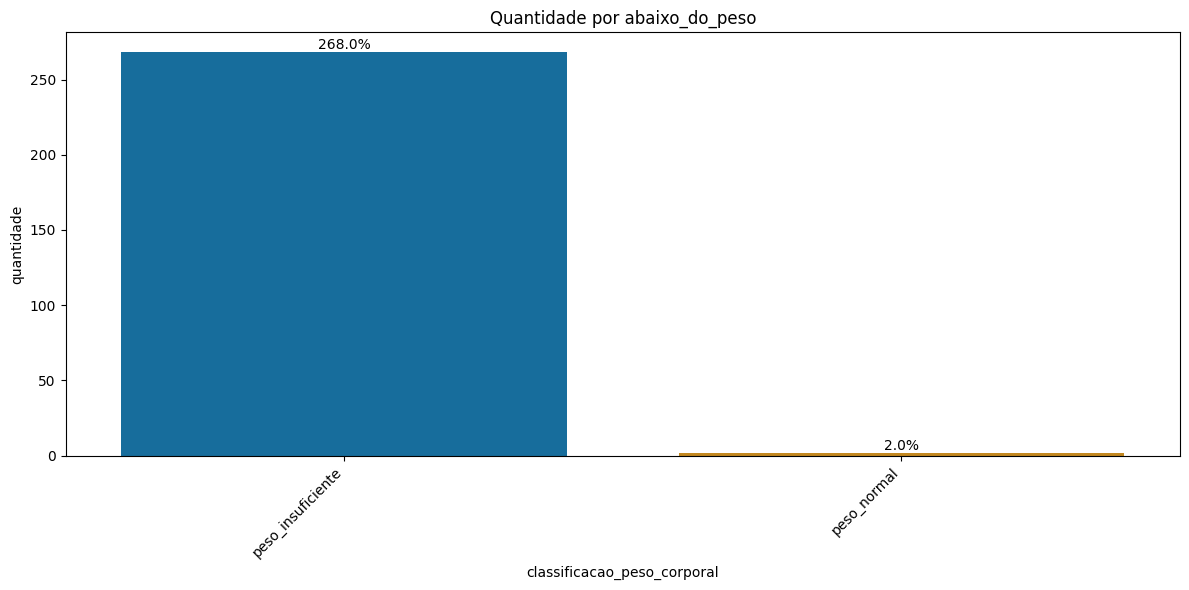


 
 
 
 
Tabela classificacao_peso_corporal por peso_normal



classificacao_peso_corporal,quantidade,porcentagem
peso_insuficiente,4,1.33
peso_normal,285,94.68
sobrepeso_tipo_1,12,3.99


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


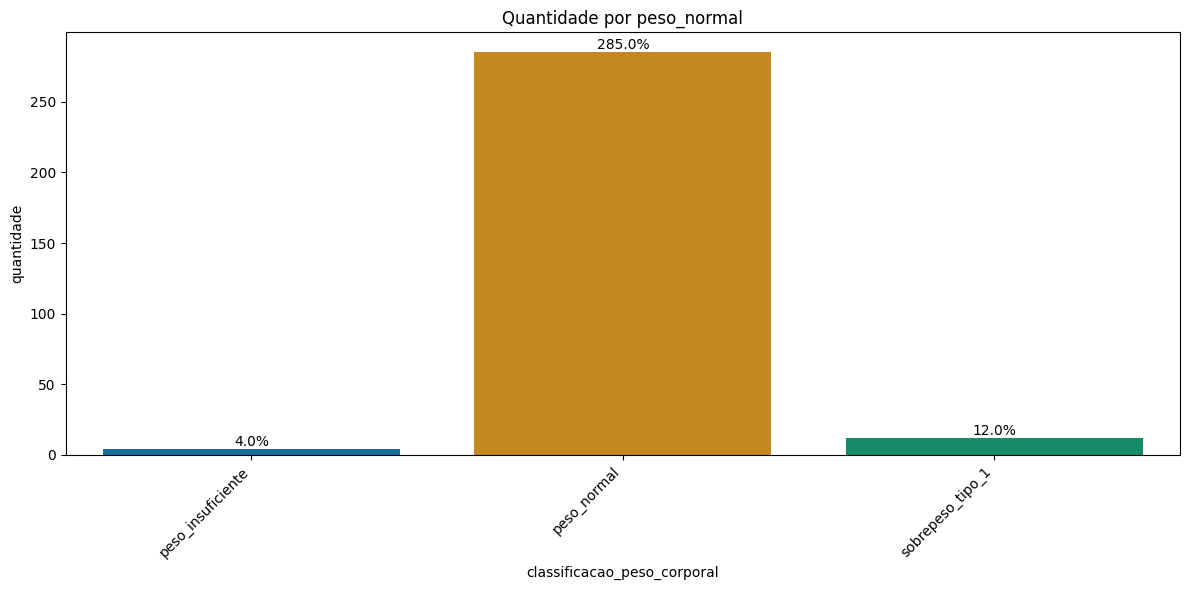


 
 
 
 
Tabela classificacao_peso_corporal por sobrepeso



classificacao_peso_corporal,quantidade,porcentagem
obesidade_tipo_1,2,0.35
sobrepeso_tipo_1,278,49.12
sobrepeso_tipo_2,286,50.53


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


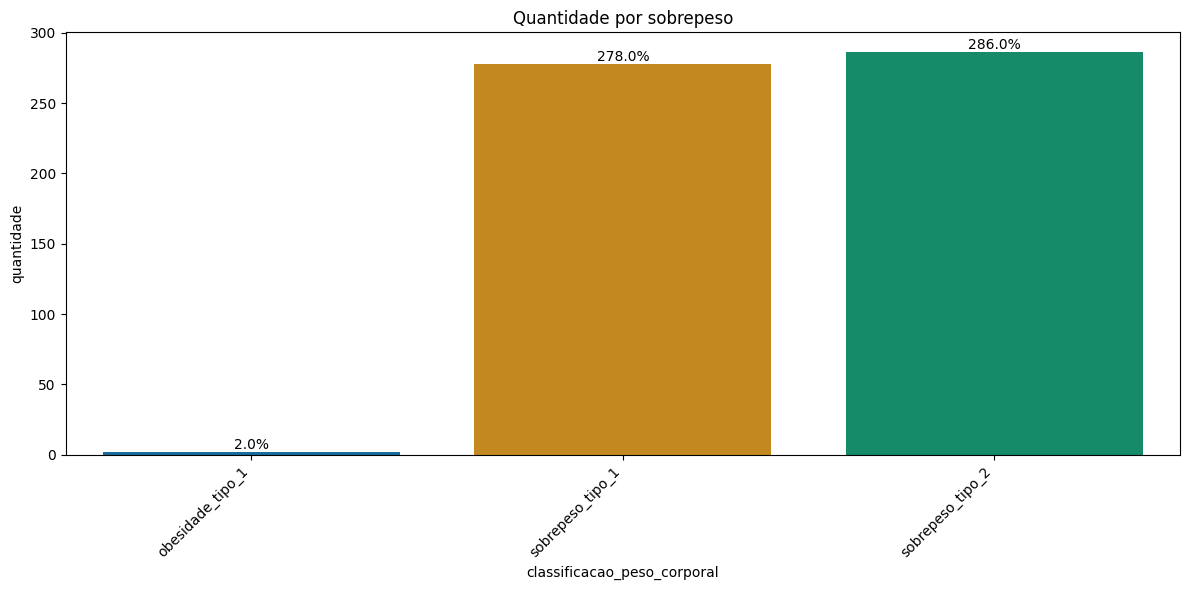


 
 
 
 
Tabela classificacao_peso_corporal por obesidade_grau_1



classificacao_peso_corporal,quantidade,porcentagem
obesidade_tipo_1,346,94.02
obesidade_tipo_2,18,4.89
sobrepeso_tipo_2,4,1.09


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


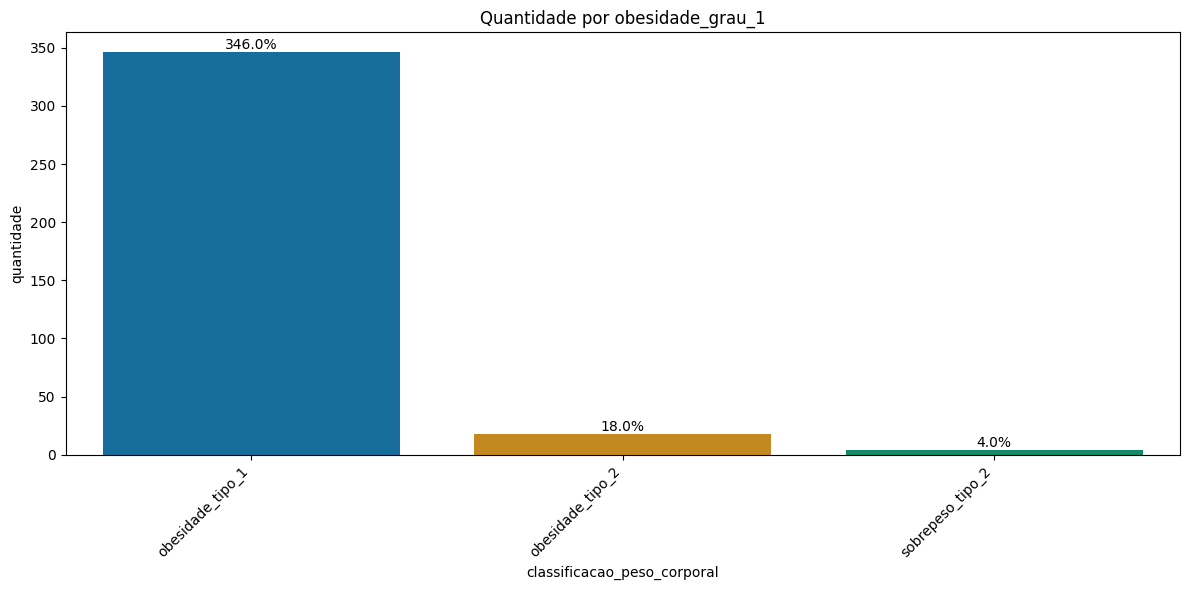


 
 
 
 
Tabela classificacao_peso_corporal por obesidade_grau_2



classificacao_peso_corporal,quantidade,porcentagem
obesidade_tipo_1,3,0.89
obesidade_tipo_2,279,82.54
obesidade_tipo_3,56,16.57


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


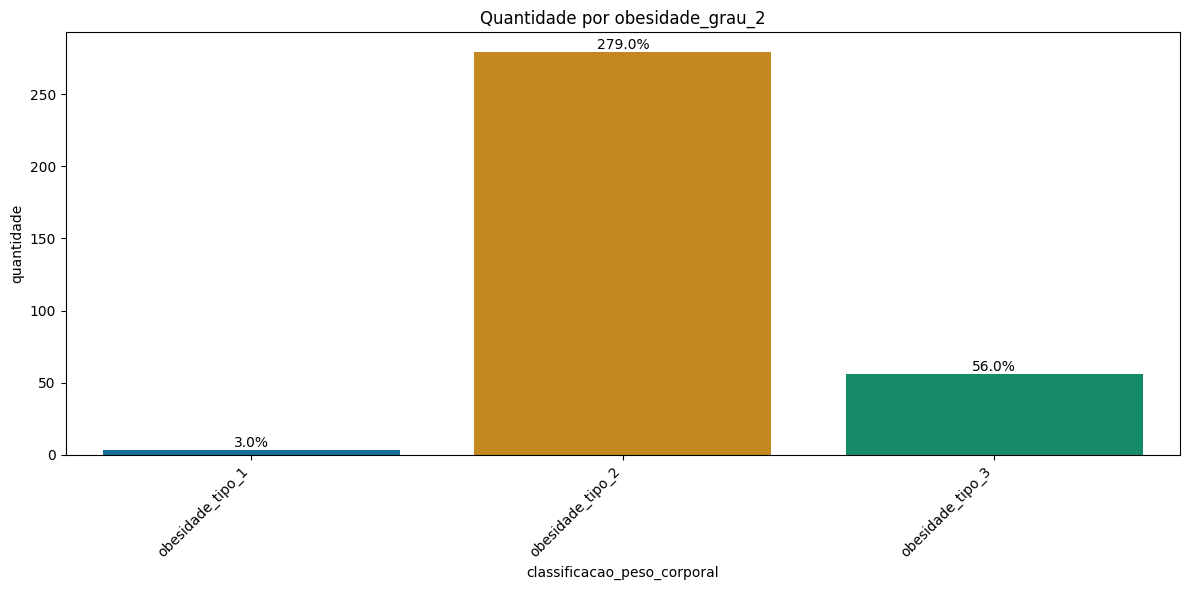


 
 
 
 
Tabela classificacao_peso_corporal por obesidade_grau_3



classificacao_peso_corporal,quantidade,porcentagem
obesidade_tipo_3,268,100.0


/tmp/ipython-input-2076254308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)


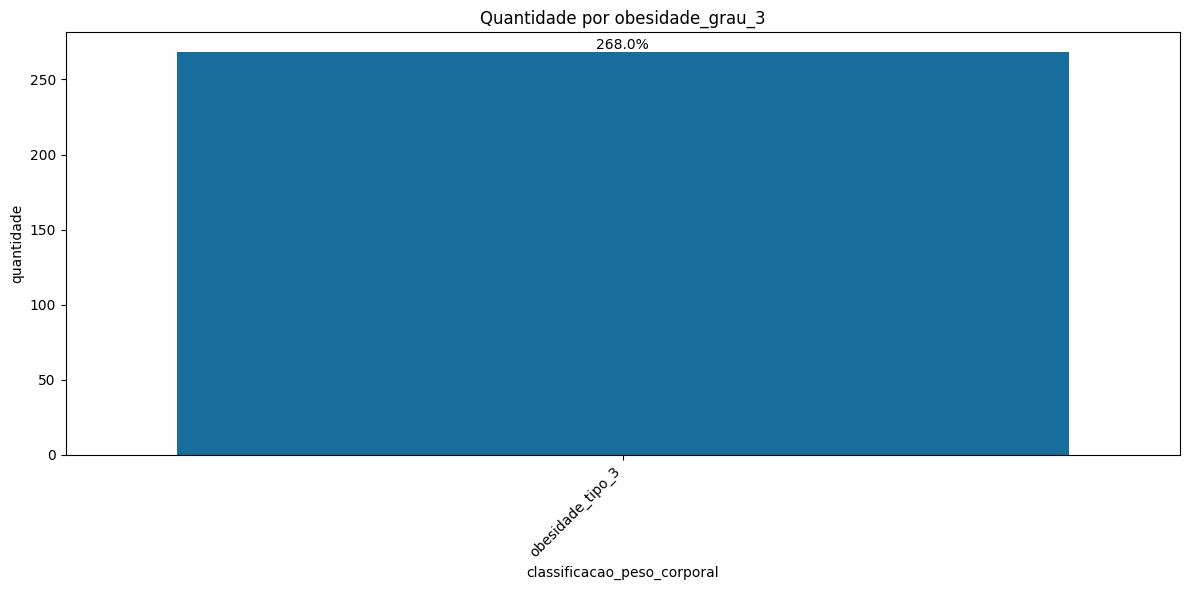

In [353]:
for chave, valor in dataframes_por_classificacao_imc.items():
  print(f'Tabela classificacao_peso_corporal por {chave}\n')
  display(HTML(valor.to_html(index=False)))
  print('\n')
  gera_grafico_barras(df= valor, x_col= 'classificacao_peso_corporal', y_col = 'quantidade', title = f"Quantidade por {chave}")
  print('\n ' * 4)

### **Distribuição da variável IMC na base**

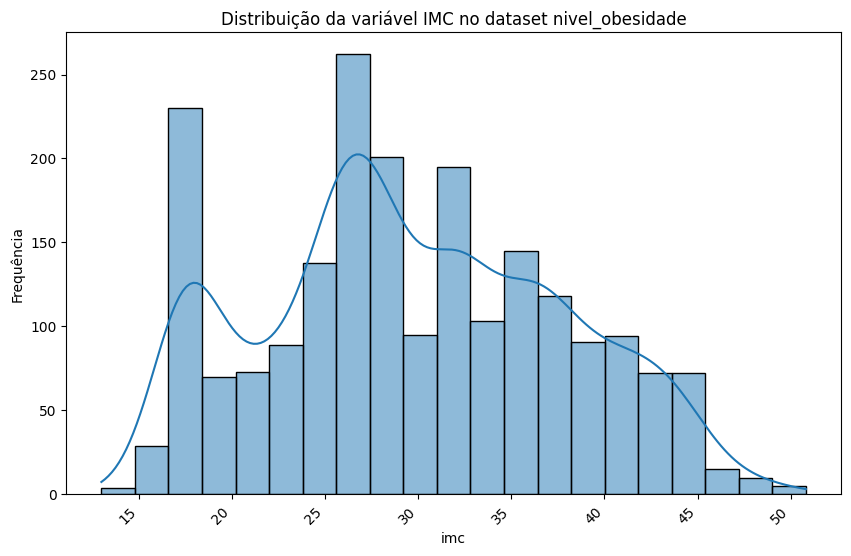

In [354]:
titulo_histograma_imc = 'Distribuição da variável IMC no dataset nivel_obesidade'
histograma_imc = gera_histograma(df, 'imc', titulo_histograma_imc)

### **nivel_obesidade por genero**

In [355]:

classificao_peso_corporal_genero_counts = round(df.groupby('classificacao_peso_corporal')['genero'].value_counts(normalize=True).mul(100).reset_index(name='porcentagem'),2)


classificao_peso_corporal_genero_pivot = classificao_peso_corporal_genero_counts.pivot(index='classificacao_peso_corporal', columns='genero', values='porcentagem').reset_index()


classificao_peso_corporal_genero_pivot.rename(columns={0: 'qtde_feminino', 1: 'qtde_masculino'}, inplace=True)



classificao_peso_corporal_genero_pivot['classificacao_peso_corporal'] = pd.Categorical(
    classificao_peso_corporal_genero_pivot['classificacao_peso_corporal'],
    categories=ordem_classificao_peso_corporal,
    ordered=True
)


classificao_peso_corporal_genero_pivot = classificao_peso_corporal_genero_pivot.sort_values('classificacao_peso_corporal').reset_index(drop=True)


display(classificao_peso_corporal_genero_pivot)

genero,classificacao_peso_corporal,Female,Male
0,peso_insuficiente,63.60,36.40
1,peso_normal,49.13,50.87
2,sobrepeso_tipo_1,50.00,50.00
3,sobrepeso_tipo_2,35.52,64.48
4,obesidade_tipo_1,44.44,55.56
5,obesidade_tipo_2,0.67,99.33
6,obesidade_tipo_3,99.69,0.31


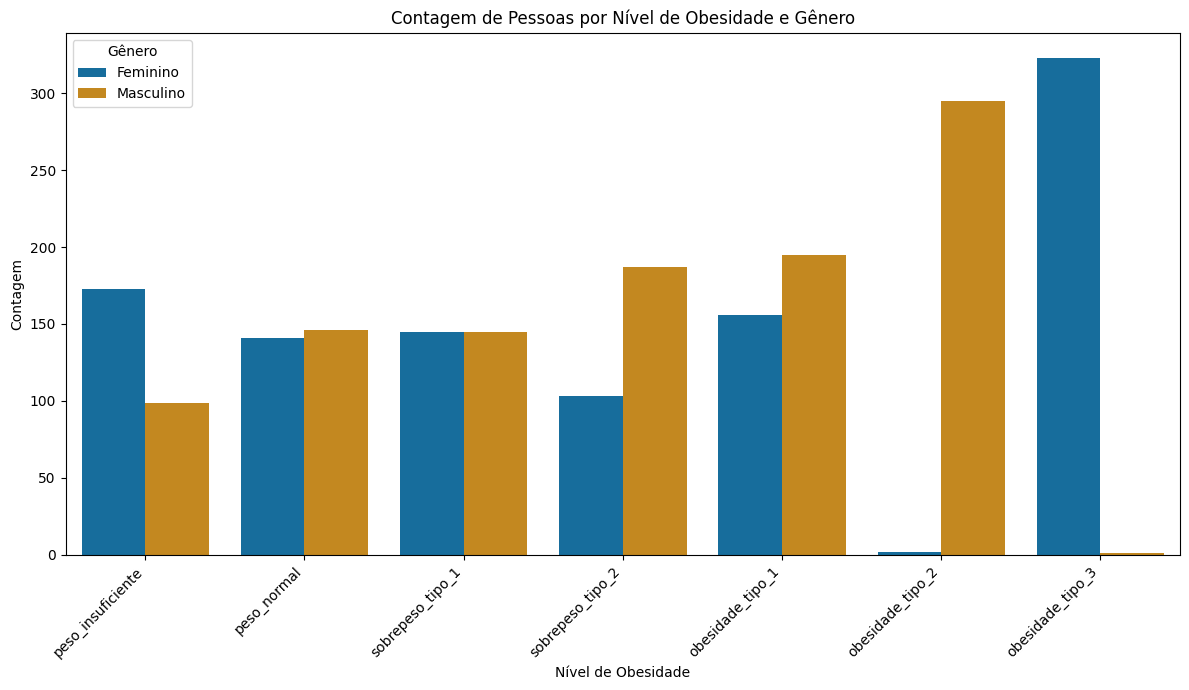

In [356]:
plt.figure(figsize=(12, 7))

sns.countplot(data=df, x='classificacao_peso_corporal', hue='genero', palette='colorblind', order=ordem_classificao_peso_corporal)

plt.xticks(ticks=range(len(ordem_classificao_peso_corporal)), labels=ordem_classificao_peso_corporal, rotation=45, ha='right')


plt.title('Contagem de Pessoas por Nível de Obesidade e Gênero')
plt.xlabel('Nível de Obesidade')
plt.ylabel('Contagem')
plt.legend(title='Gênero', labels=['Feminino', 'Masculino']) # Ajustar rótulos da legenda
plt.tight_layout()
plt.show()

# **Análise de variáveis**

## **Pesquisa teórica**

Existem vários métodos para avaliar a gordura corporal. A densitometria por absorciometria radiológica de dupla energia (DEXA) é o padrão ouro, utilizando raios X para medir com precisão a composição corporal, incluindo percentual de gordura, massa muscular, massa óssea e gordura visceral. Outros métodos incluem circunferência da cintura, relação cintura-quadril, exames de bioimpedância e o Body Roundness Index (BRI).


O Índice de Massa Corporal (IMC) é prático e econômico para triagem populacional, mas pode superestimar a gordura em pessoas ativas e subestimar em sedentários, obesos, idosos e em certas condições clínicas. Por isso, é recomendado associar o IMC a outras medidas de gordura, como a circunferência da cintura, e, se possível, a exames de composição corporal.


Estudos mostram que combinar o IMC com informações comportamentais e padrões alimentares melhora a previsão da obesidade. Essa abordagem integrada, que considera hábitos alimentares, atividade física, sono e estilo de vida, permite identificar padrões, orientar intervenções preventivas e promover mudanças de comportamento. Modelos que associam dados antropométricos (IMC, peso e altura) a hábitos alimentares ajudam a prever não apenas o diagnóstico atual, mas também a propensão ao ganho de peso e obesidade futura, oferecendo uma estratégia mais completa para prevenção e tratamento, com benefícios para a saúde pública e clínica.


## **Análise variável alvo: classificacao_peso_corporal**

**Técnicas aplicadas:**
  
  -  Tabela de frequencia,
  - Gráfico de barras
  - O Teste de Aderência, utilizando qui-quadrado
  - Razão de Desbalanceamento

**Análise:**

A amostra se mostra estatisticamente desbalanceada em relação as classes da variável alvo classificação_peso_corporal, no entanto ao calcular a razão de desbalanceamento verificou-se que a amostra é suficientemente balanceada para o treinamento inicial de um modelo de machine learning.

**Tabela de frequência**

In [357]:
tab_freq_classificacao_peso_corporal = criar_dataframe_frequencia(df, 'classificacao_peso_corporal')
display(tab_freq_classificacao_peso_corporal)
print('\n')
print('Porcentagens:\n')
print(f"Porcentagem mínima de uma categoria: {round(tab_freq_classificacao_peso_corporal['porcentagem'].min(),1)}")
print(f"Porcentagem máxima de uma categoria: {round(tab_freq_classificacao_peso_corporal['porcentagem'].max(),1)}")


,categoria,quantidade,porcentagem
0,obesidade_tipo_1,351,16.63
1,obesidade_tipo_3,324,15.35
2,obesidade_tipo_2,297,14.07
3,sobrepeso_tipo_1,290,13.74
4,sobrepeso_tipo_2,290,13.74
5,peso_normal,287,13.60
6,peso_insuficiente,272,12.88




Porcentagens:

Porcentagem mínima de uma categoria: 12.9
Porcentagem máxima de uma categoria: 16.6


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


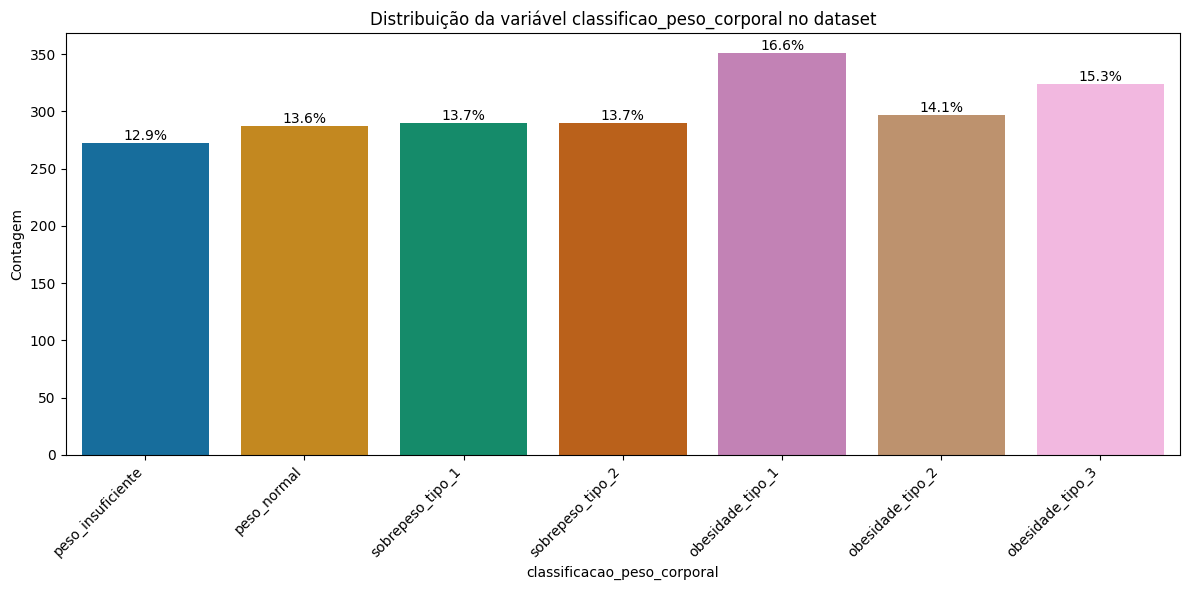

In [358]:
gera_grafico_barras(df, 'classificacao_peso_corporal', title = "Distribuição da variável classificao_peso_corporal no dataset", order = ordem_classificao_peso_corporal)

**Teste de Aderência utilizando Qui-Quadrado**

In [359]:
frequencias_observadas_classificacao_peso = tab_freq_classificacao_peso_corporal['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_classificacao_peso, f_esperadas=None)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 14.3306
Valor-p (p-value): 0.0262
Como p (0.0262) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(14.330648981525345), np.float64(0.02615299868612885))

**Razão de desbalanceamento**

In [360]:
qtd_min_classificacao_peso_corporal = tab_freq_classificacao_peso_corporal['porcentagem'].min()
qtd_max_classificacao_peso_corporal = tab_freq_classificacao_peso_corporal['porcentagem'].max()
razao_balancemento_classificacao_peso_corporal = calcular_razao_desbalanceamento(quantidade_maxima = qtd_max_classificacao_peso_corporal, quantidade_minima = qtd_min_classificacao_peso_corporal)



--- Razão de Desbalanceamento (IR) ---
Quantidade da classe majoritária: 16.63
Quantidade da classe minoritária: 12.88
Razão de Desbalanceamento (IR): 1.29

--- Interpretação da Razão de Desbalanceamento ---
🟢 Balanceado. Não faça nada.


## **Análise variáveis categóricas nominais**

`genero`, `historico_familiar`, `favc`,  `fumante`, `scc`, `mtrans`

**Técnicas utilizadas:**

**Analise univarida:**

- Tabela de frequência
- Gráfico de barras
- Teste de aderência (univariado) utilizando qui-quadrado

**Análise bi-variada:**

- Tabela cruzada
- Gráfico de barras emoilhado
- Teste de Independência (Bivariado) utilizando qui-quadrado

### **Análise variável `genero`**

In [361]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['genero']['novo_nome']}: {dicionario_dados_nivel_obesidade['genero']['descricao']}")

Descrição da variavel genero: Genero


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente balanceada em relação aos grupos que compõe a variável gênero.

A análise bi-variada apresenta um gráfico empilhado onde as barras de feminino e masculino da variável gênero estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `genero`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando a técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [362]:
tab_freq_classificacao_genero = criar_dataframe_frequencia(df = df, coluna = 'genero')
display(tab_freq_classificacao_genero)

,categoria,quantidade,porcentagem
0,Male,1068,50.59
1,Female,1043,49.41


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


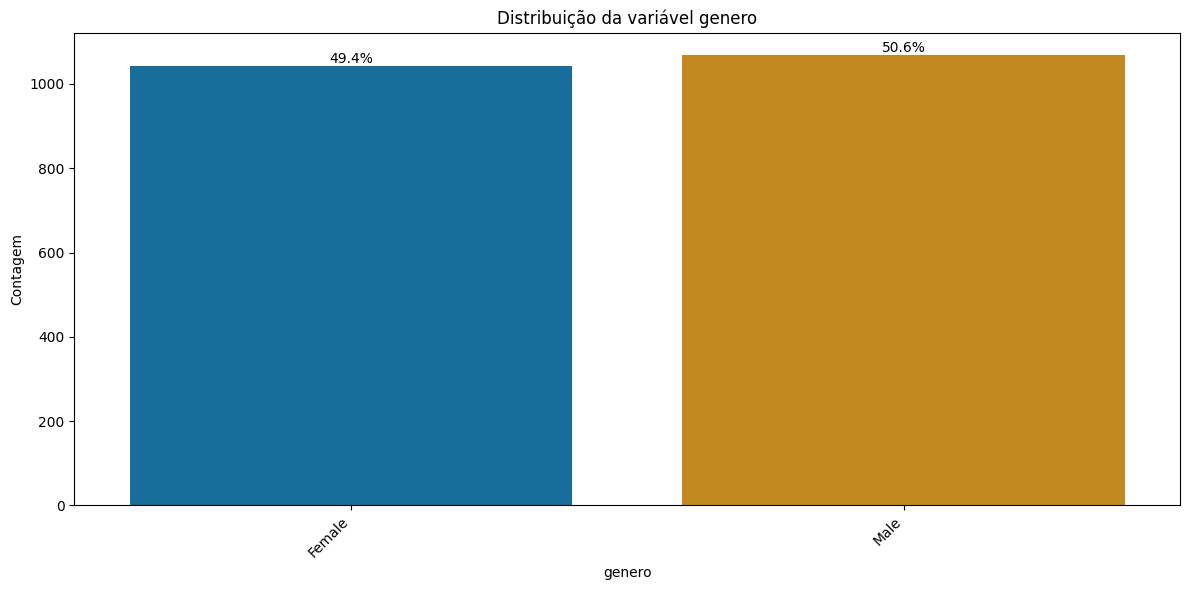

In [363]:
gera_grafico_barras(df = df , x_col = 'genero', title = "Distribuição da variável genero")

***Teste de aderência (univariado)***

In [364]:
frequencias_observadas_genero = tab_freq_classificacao_genero['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_genero)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 0.2961
Valor-p (p-value): 0.5864
Como p (0.5864) > 0.05, não podemos rejeitar a Hipótese Nula (H0).
Conclusão: A distribuição PODE ser considerada estatisticamente balanceada.


(np.float64(0.29606821411653245), np.float64(0.5863578616481406))

**Análise Bi-variada**

`genero` vs `classificacao_peso_alvo`

--- Análise da Feature: 'genero' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 657.7462
P-valor (p-value): 8.089e-139
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
genero,,,,,,,
Female,16.59,13.52,13.90,9.88,14.96,0.19,30.97
Male,9.27,13.67,13.58,17.51,18.26,27.62,0.09


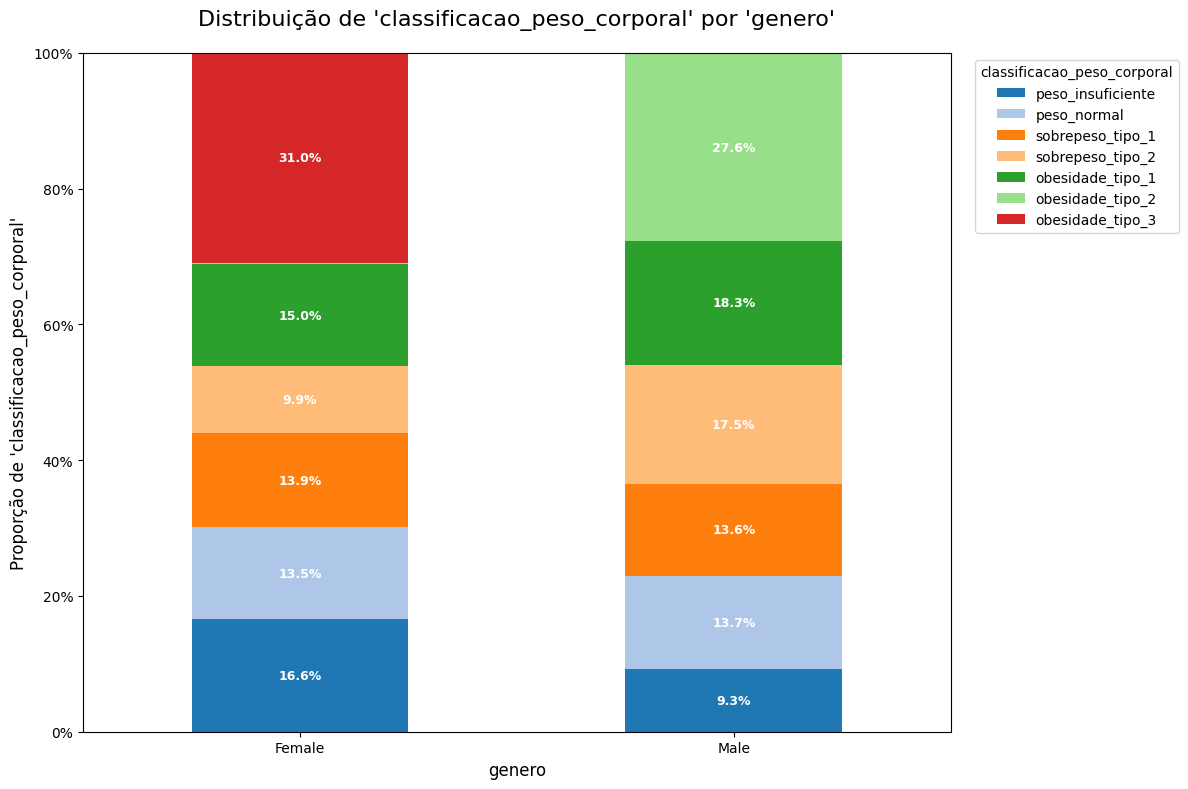

In [365]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'genero',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `historico_familiar`**

In [366]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['historico_familiar']['novo_nome']}: {dicionario_dados_nivel_obesidade['historico_familiar']['descricao']}")

Descrição da variavel historico_familiar: Algum membro da familia sofreu ou sofre de excesso de peso?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável historico_familiar. No entanto, ainda temos uma amostra grande o suficiente do grupo minotário para alimentar o modelo de machine learning.

A análise bi-variada apresenta um gráfico empilhado onde as barras de sim e  não da variável historico_familiar estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é uma candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `historico_familiar`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando a técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [367]:
tab_freq_classificacao_historico_familiar = criar_dataframe_frequencia(df = df, coluna = 'historico_familiar')
display(tab_freq_classificacao_historico_familiar)

,categoria,quantidade,porcentagem
0,yes,1726,81.76
1,no,385,18.24


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


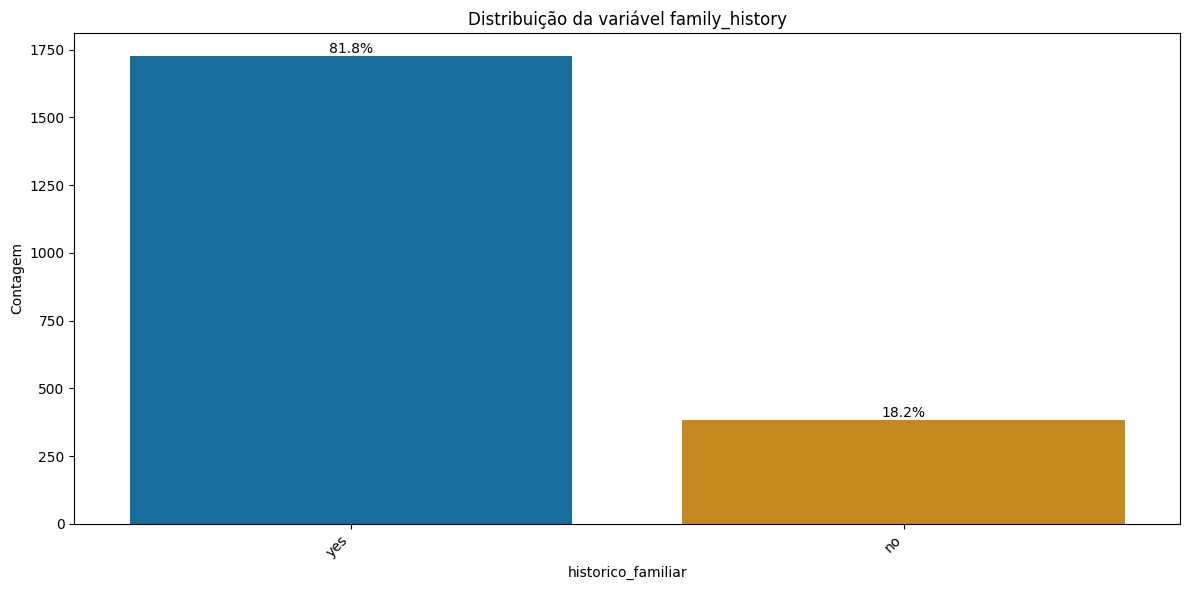

In [368]:
gera_grafico_barras(df = df , x_col = 'historico_familiar', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['historico_familiar']['nome_original']}")

***Teste de aderência (univariado)***

In [369]:
frequencias_observadas_historico_familiar = tab_freq_classificacao_historico_familiar['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_historico_familiar)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 851.8622
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(851.8621506395074), np.float64(2.862407015229573e-187))

**Análise Bi-variada**

`frequencias_observadas_historico_familiar` vs `classificacao_peso_alvo`

--- Análise da Feature: 'historico_familiar' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 621.9794
P-valor (p-value): 4.228e-131
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
historico_familiar,,,,,,,
no,37.92,34.29,21.04,4.68,1.82,0.26,0.00
yes,7.30,8.98,12.11,15.76,19.93,17.15,18.77


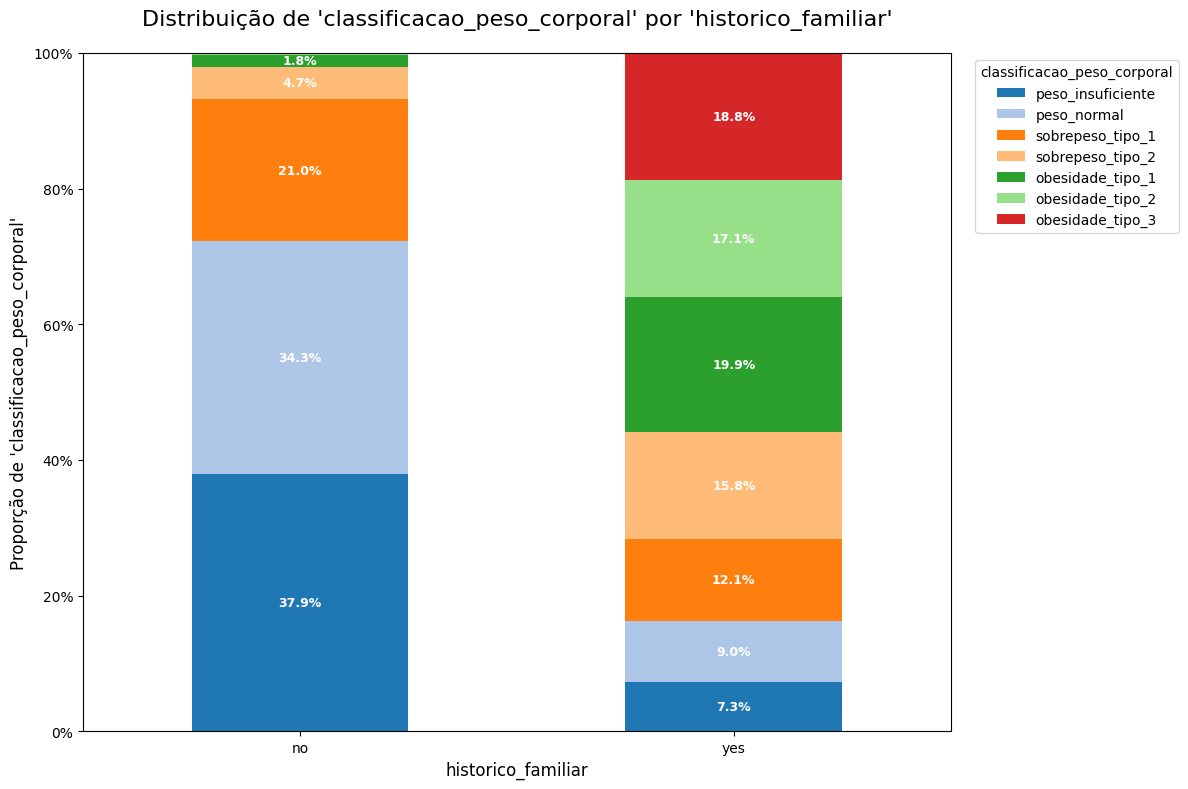

In [370]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'historico_familiar',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `favc`**

In [371]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['favc']['nome_original']}: {dicionario_dados_nivel_obesidade['favc']['descricao']}")

Descrição da variavel FAVC: Voce come alimentos altamente caloricos com frequencia?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável favc. No entanto, ainda temos uma amostra grande o suficiente do grupo minotário para alimentar o modelo de machine learning.

A análise bi-variada apresenta um gráfico empilhado onde as barras de sim e  não da variável favc estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é uma candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `favc`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando uma técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [372]:
tab_freq_classificacao_favc = criar_dataframe_frequencia(df = df, coluna = 'favc')
display(tab_freq_classificacao_favc)

,categoria,quantidade,porcentagem
0,yes,1866,88.39
1,no,245,11.61


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


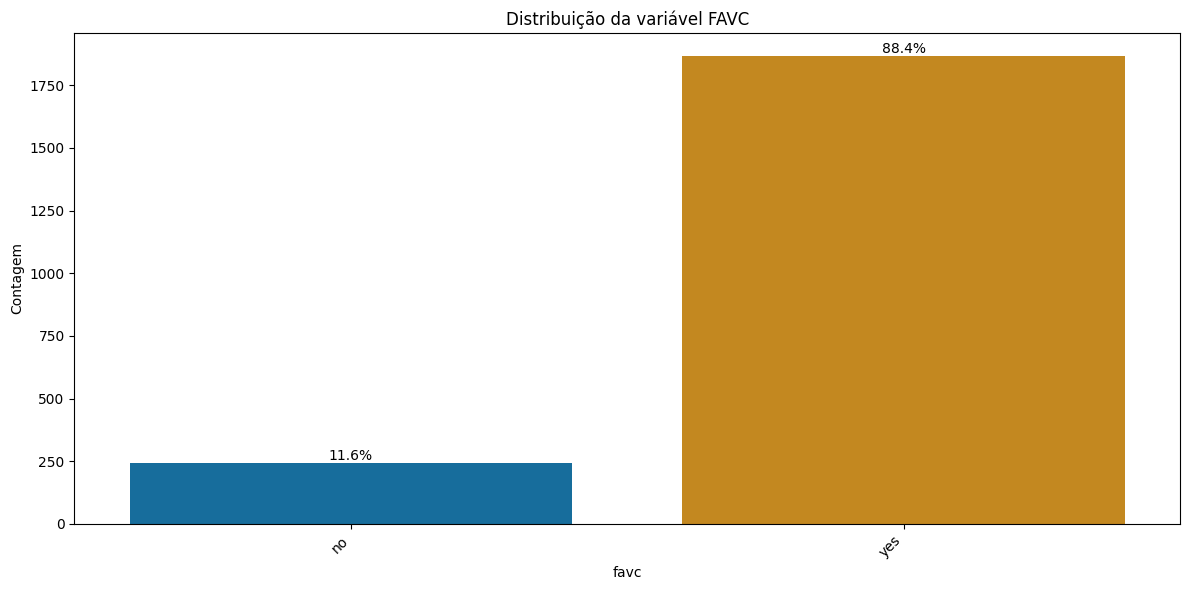

In [373]:
gera_grafico_barras(df = df , x_col = 'favc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['favc']['nome_original']}")

***Teste de aderência (univariado)***

In [374]:
frequencias_observadas_favc = tab_freq_classificacao_favc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_favc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1244.7376
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1244.7375651350071), np.float64(1.1553803549669082e-272))

**Análise Bi-variada**

`favc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'favc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 233.3413
P-valor (p-value): 1.482e-47
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
favc,,,,,,,
no,20.82,32.24,8.98,30.20,4.49,2.86,0.41
yes,11.84,11.15,14.36,11.58,18.22,15.54,17.31


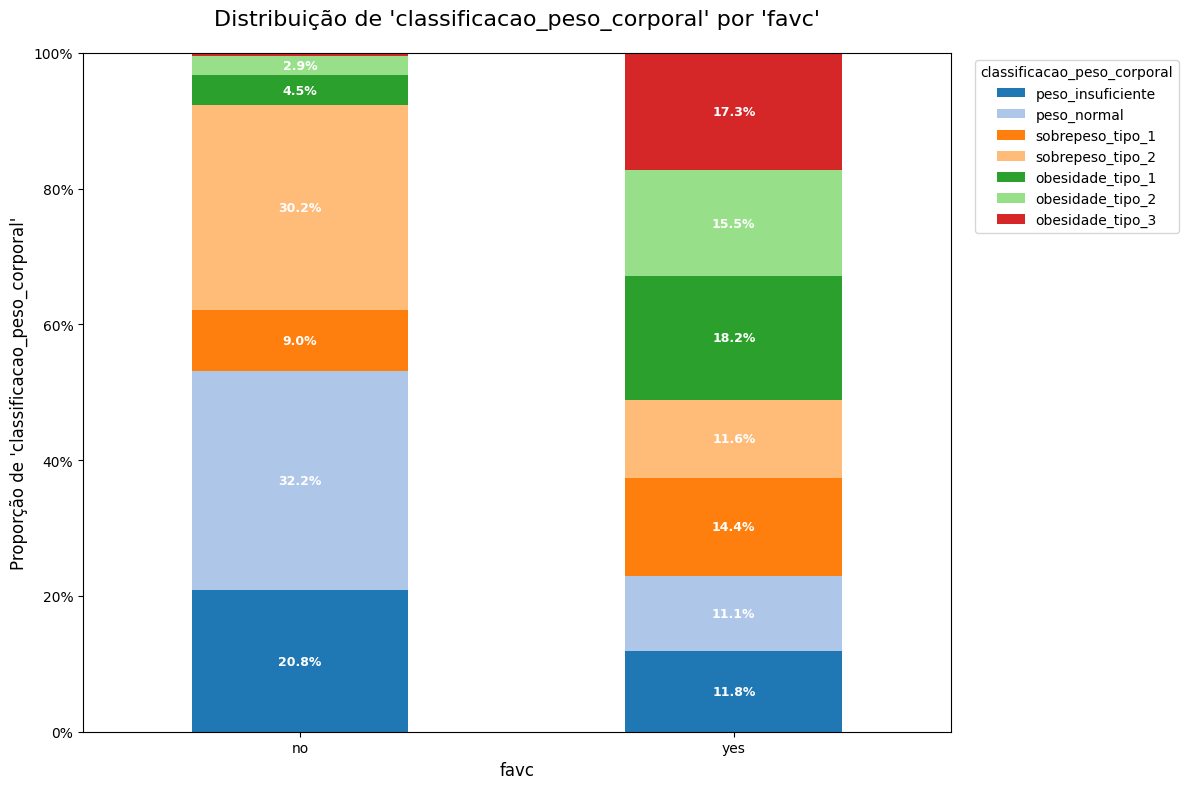

In [375]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'favc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `fumante`**

In [376]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['fumante']['novo_nome']}: {dicionario_dados_nivel_obesidade['fumante']['descricao']}")

Descrição da variavel fumante: Voce fuma?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável fumante e temos uma amostra pequena do grupo sim.

Devido a esse motivo, apesar da análise bi-variada uma associação estatisticamente relevante no teste qui-quadrado, a recomendação é de não usar essa feature no modelo preditivo pois o risco de overfiting é maior que o possível ganho.


**Sugestão para a feature `fumante`:**

- Excluir a feature do modelo preditivo.

- Caso optem por utilizar a feature é necessário realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando uma técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [377]:
tab_freq_classificacao_fumante = criar_dataframe_frequencia(df = df, coluna = 'fumante')
display(tab_freq_classificacao_fumante)

,categoria,quantidade,porcentagem
0,no,2067,97.92
1,yes,44,2.08


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


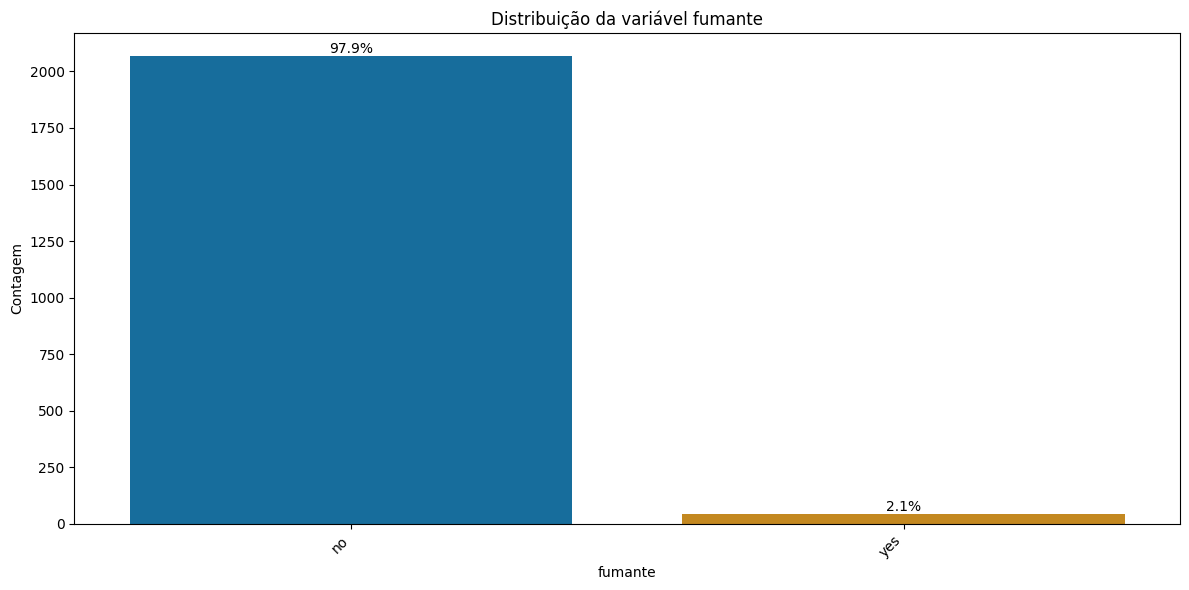

In [378]:
gera_grafico_barras(df = df , x_col = 'fumante', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['fumante']['novo_nome']}")

***Teste de aderência (univariado)***

In [379]:
frequencias_observadas_fumante = tab_freq_classificacao_fumante['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_fumante)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1938.6684
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1938.6684036001895), np.float64(0.0))

**Análise Bi-variada**

`favc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'fumante' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 32.1378
P-valor (p-value): 1.535e-05
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
fumante,,,,,,,
no,13.11,13.26,13.88,13.79,16.69,13.64,15.63
yes,2.27,29.55,6.82,11.36,13.64,34.09,2.27


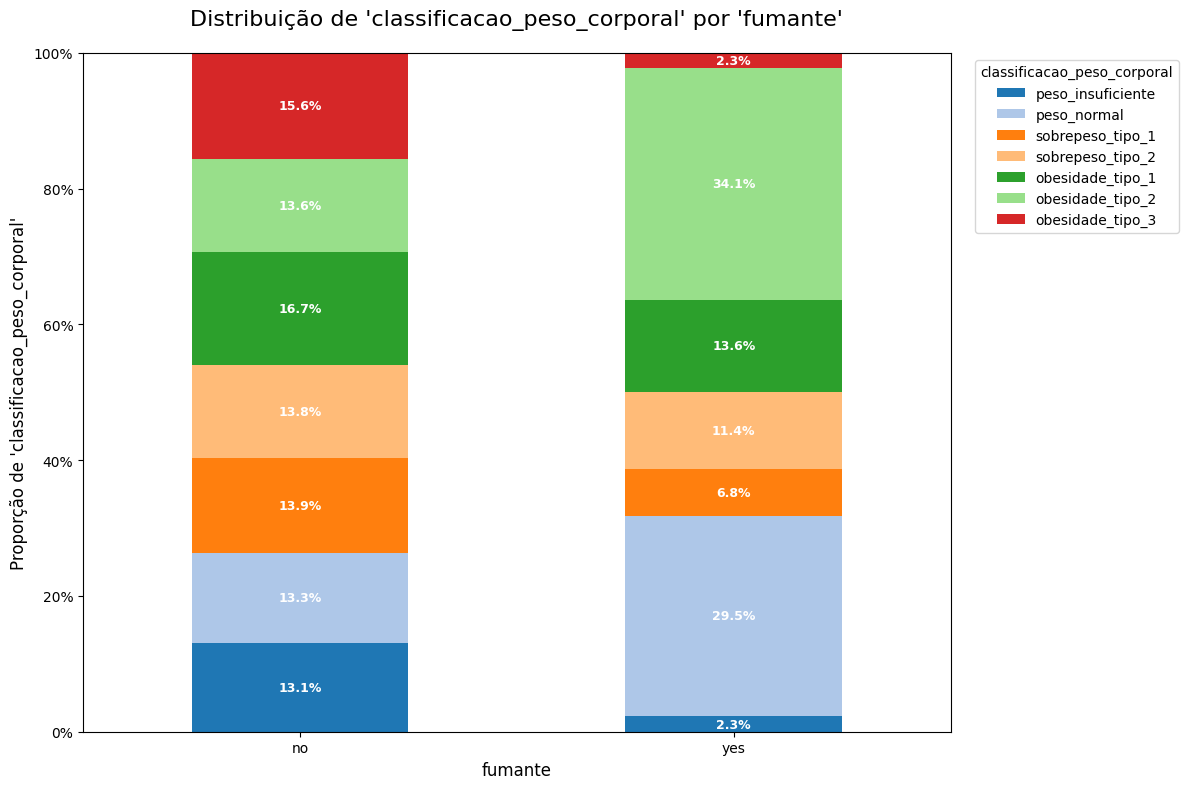

In [380]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'fumante',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `scc`**

In [381]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['scc']['nome_original']}: {dicionario_dados_nivel_obesidade['scc']['descricao']}")

Descrição da variavel SCC: Voce monitora as calorias que ingere diariamente?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável fumante e temos uma amostra pequena do grupo sim. O volume de amostras está em uma zona de atenção devido ao risco de overfitting. No entanto a associação preditiva é significativamente relevante.


**Sugestão para a feature `scc`:**

- Manter a feature para o treinamento do modelo preditivo.

- Após o treinamento Verificar a importância da feature. Se a importância dela for pequena para o modelo,  retirar a feature do treinamento do modelo é uma boa opção.

- Realizar a validação cruzada para ter certeza  se devemos continuar ou não com a feature.

- Caso optem por utilizar a feature é necessário realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [382]:
tab_freq_classificacao_scc = criar_dataframe_frequencia(df = df, coluna = 'scc')
display(tab_freq_classificacao_scc)

,categoria,quantidade,porcentagem
0,no,2015,95.45
1,yes,96,4.55


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


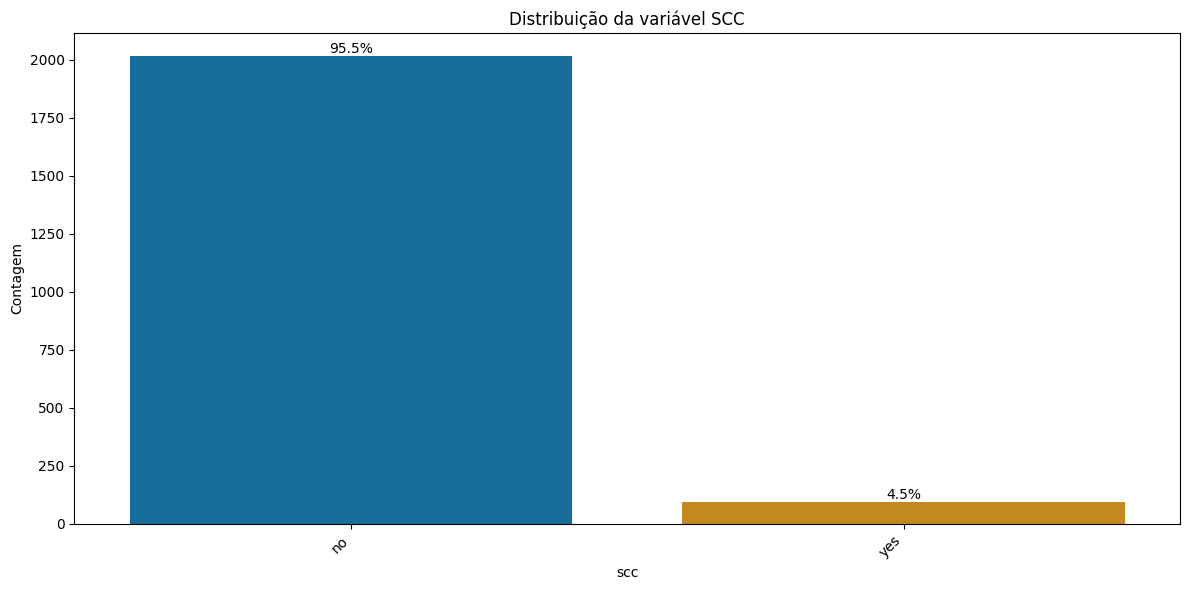

In [383]:
gera_grafico_barras(df = df , x_col = 'scc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['scc']['nome_original']}")

***Teste de aderência (univariado)***

In [384]:
frequencias_observadas_scc = tab_freq_classificacao_scc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_scc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1744.4628
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1744.462813832307), np.float64(0.0))

**Análise Bi-variada**

`scc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'scc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 123.0239
P-valor (p-value): 3.773e-24
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
scc,,,,,,,
no,12.41,12.75,12.56,14.19,17.32,14.69,16.08
yes,22.92,31.25,38.54,4.17,2.08,1.04,0.00


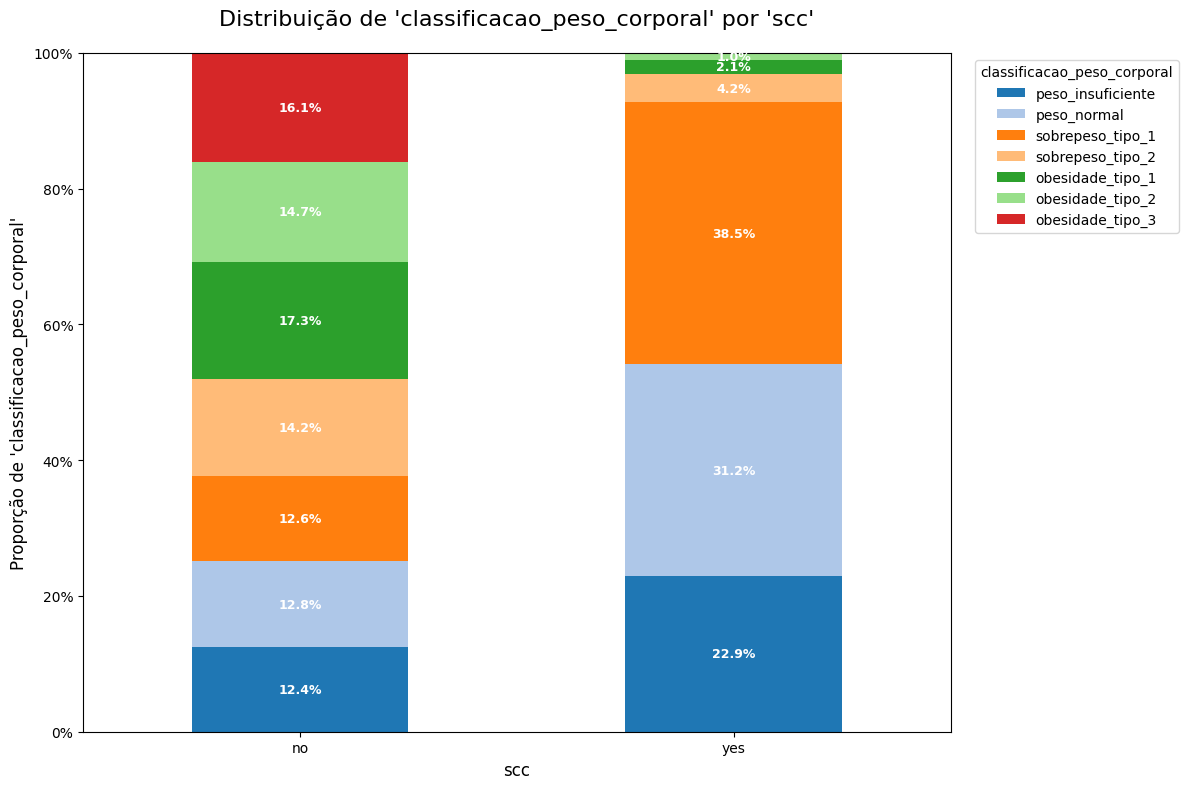

In [385]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'scc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `mtrans`**

In [386]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['mtrans']['nome_original']}: {dicionario_dados_nivel_obesidade['mtrans']['descricao']}")

Descrição da variavel MTRANS: Qual meio de transporte voce costuma usar?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável mtrans. No entanto as amostras de `transporte_publico` (1580), `carro` (457) possuem uma boa quantidade de registros para realizar o treinamento do modelo. A quantidade de valores de `bicicleta` (7),  `moto`(11) estão em uma zonas de descarte devido a baixa volumetria, enquanto `caminhando` (56) está em uma zona de cuidado.

A análise bivariada mostrou uma associação estatisticamente relevante entre as categorias e a variável alvo. As categorias raras `bicicleta` (7),  `moto`(11) e  `andando` (56) possuem um padrão parecido com acumulo de registros relacionados a `peso_normal`e `baixa obesidade`. Dessa forma é possível agrupá-las em uma única categoria para treinamento, deixando elas ainda na zona de atenção devido a quantidade de 74 casos, mas com a possibilidade de utilização devido ao potencial preditivo.


**Sugestão para a feature `mtrans`:**

- Transformar as categorias `bicicleta`,  `moto` e  `caminhando` em uma única categoria .

- Utilizar a técnica `one_hot_encoding` transformando em 2 categorias para evitar a armadilha das Variáveis Dummy.

- Após o treinamento Verificar a importância da feature. Se a importância dela for pequena para o modelo, retirar a feature do treinamento do modelo é uma boa opção.

- Realizar a validação cruzada para ter certeza  se devemos continuar ou não com a feature.



**Análise univariada**

**Tabela de Frequência**

In [387]:
tab_freq_classificacao_mtrans = criar_dataframe_frequencia(df = df, coluna = 'mtrans')
display(tab_freq_classificacao_mtrans)

,categoria,quantidade,porcentagem
0,transporte_publico,1580,74.85
1,carro,457,21.65
2,caminhando,56,2.65
3,moto,11,0.52
4,bicicleta,7,0.33


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


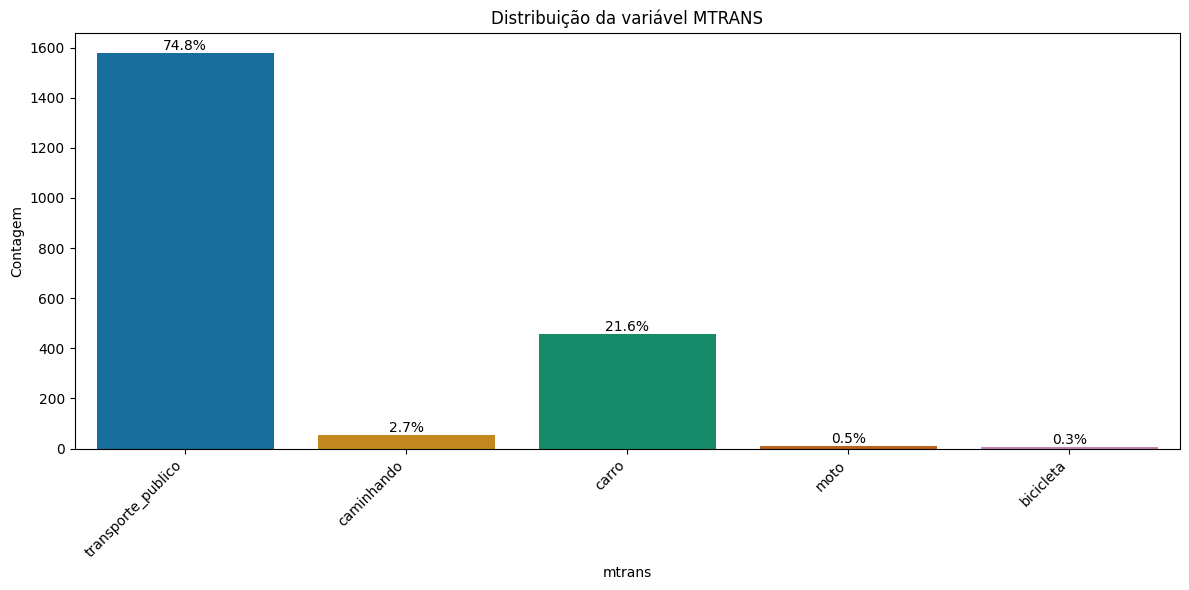

In [388]:
gera_grafico_barras(df = df , x_col = 'mtrans', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['mtrans']['nome_original']}")

***Teste de aderência (univariado)***

In [389]:
frequencias_observadas_mtrans = tab_freq_classificacao_mtrans['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_mtrans)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 4304.3363
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(4304.3363334912365), np.float64(0.0))

**Análise Bi-variada**

`mtrans` vs `classificacao_peso_alvo`

--- Análise da Feature: 'mtrans' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 292.5939
P-valor (p-value): 5.178e-48
Graus de Liberdade (dof): 24


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
mtrans,,,,,,,
bicicleta,0.00,57.14,28.57,0.00,0.00,14.29,0.00
caminhando,10.71,57.14,16.07,10.71,3.57,1.79,0.00
carro,10.07,9.85,14.44,20.57,24.07,20.79,0.22
moto,0.00,54.55,9.09,9.09,27.27,0.00,0.00
transporte_publico,13.92,12.66,13.42,11.96,14.94,12.66,20.44


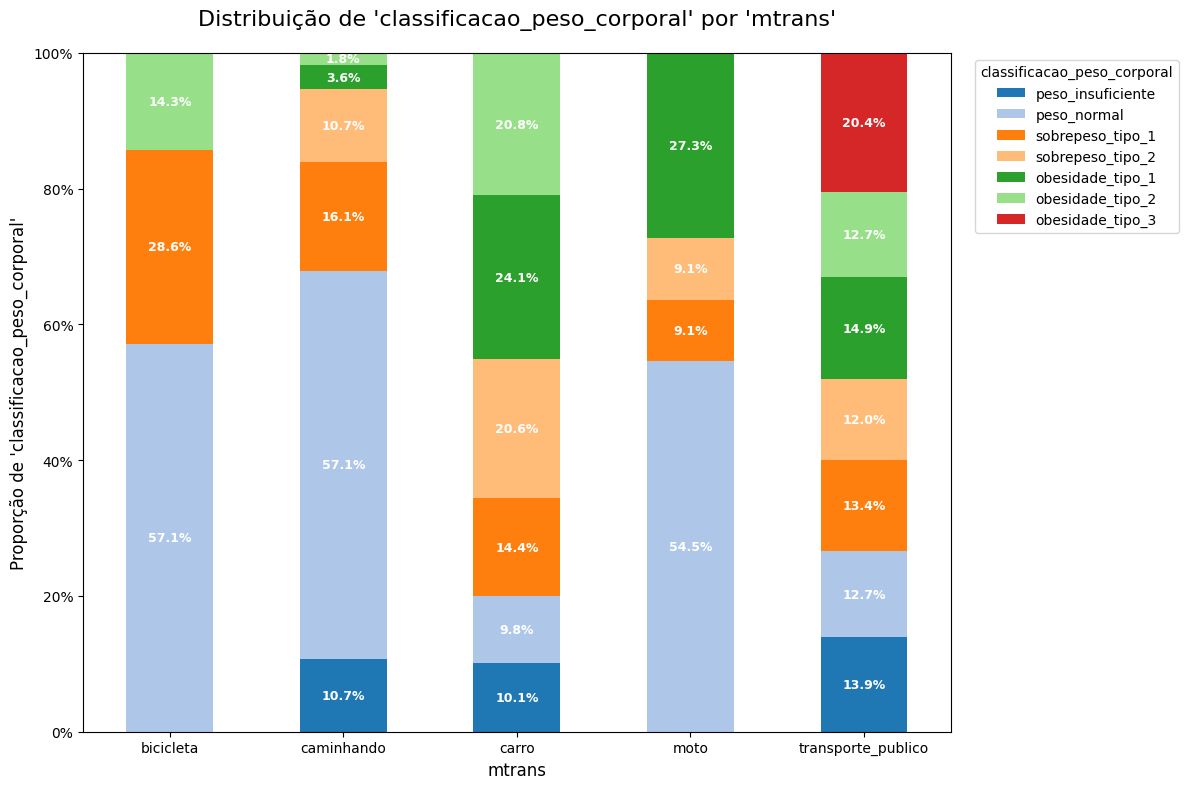

In [422]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'mtrans',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

## **Análise variáveis categóricas ordinais**

**Variáveis categóricas ordinais:**

`caec`, `calc`

**Técnicas utilizadas:**

**Analise univarida:**

- Tabela de frequência
- Gráfico de barras
- Teste de aderência (univariado) utilizando qui-quadrado

**Análise bi-variada:**

- Tabela cruzada
- Gráfico de barras emoilhado
- Teste de Independência (Bivariado) utilizando qui-quadrado

### **Análise variável `caec`**

In [407]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['caec']['novo_nome']}: {dicionario_dados_nivel_obesidade['caec']['descricao']}")

Descrição da variavel caec: Voce come alguma coisa entre as refeicoes?


**Valores únicos da variável**

In [408]:
print(f'Os valores únicos da variável {dicionario_dados_nivel_obesidade["caec"]["novo_nome"]} são: {df.caec.unique()}')

Os valores únicos da variável caec são: ['as_vezes' 'frequentemente' 'sempre' 'nunca']


**Conclusão:**

A variável caec é uma amostra desbalanceada, com `nunca` e `sempre` no limite inferior entre a zona de perigo e descarte de uma variável. A analise bivariada sinalizou um associação estatisticamente significante. Diferente da coluna `mtrans` juntar categorias não é uma opção, pois elas possuem associações bem diferentes com a variavel alvo.

Neste caso devido ao poder preditivo sugiro manter a feature no treinamento utilizando a tecnica de ordinal_encoder, mas analisaria a relevancia da mesma no treinamento do modelo para verificar se devemos mante-la e assumir o risco de overfitting.


**Sugestão para a feature `caec`:**

- Utilizar a técnica `OrdinalEncoder`.

- Verificar a importância da feature.

- Teste A/B comparando os scores na validação cruzada

- Caso a importância da feature  e o teste A/B voltem sem relevância ou indicando overfitting retirar a mesma do treinamento.



**Análise univariada**

**Tabela de Frequência**

In [415]:
tab_freq_classificacao_caec = criar_dataframe_frequencia(df = df, coluna = 'caec', ordem_categorias = ordem_frequencia)
display(tab_freq_classificacao_caec)

,categoria,quantidade,porcentagem
0,nunca,51,2.42
1,as_vezes,1765,83.61
2,frequentemente,242,11.46
3,sempre,53,2.51


**Gráfico de barras**

In [412]:
ordem_frequencia

['nunca', 'as_vezes', 'frequentemente', 'sempre']

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


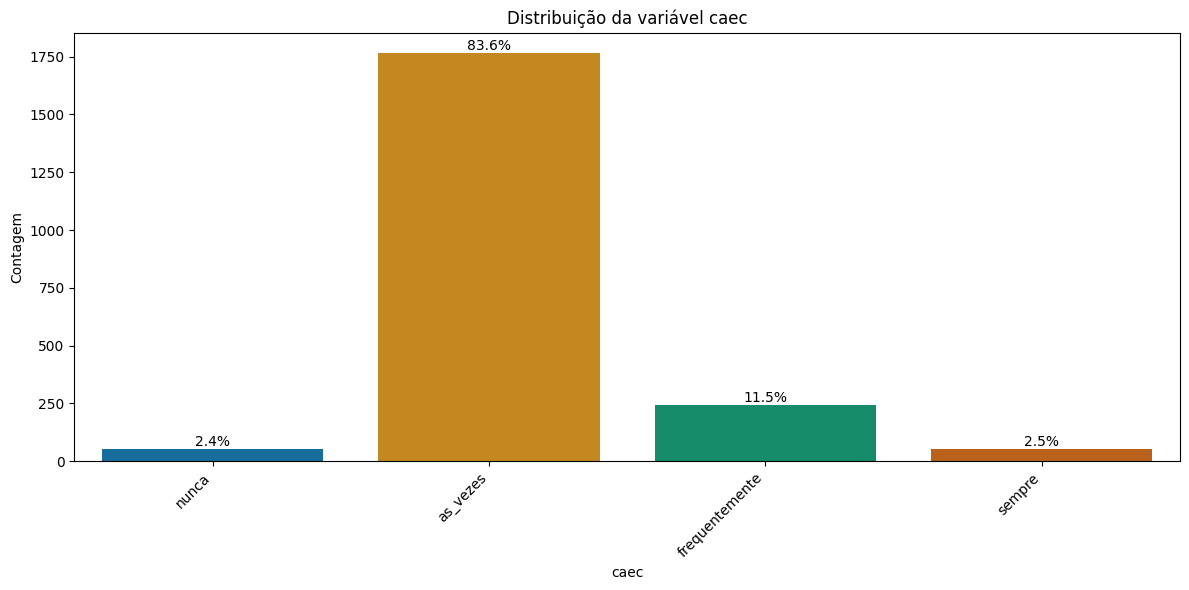

In [414]:
gera_grafico_barras(df = df , x_col = 'caec', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['caec']['novo_nome']}", order = ordem_frequencia)

***Teste de aderência (univariado)***

In [417]:
frequencias_observadas_caec = tab_freq_classificacao_caec['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_caec)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 3913.0625
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(3913.0625296068215), np.float64(0.0))

**Análise Bi-variada**

`caec` vs `classificacao_peso_alvo`

--- Análise da Feature: 'caec' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 802.9773
P-valor (p-value): 7.384e-159
Graus de Liberdade (dof): 18


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de linhas (eixo X) aplicada: ['nunca', 'as_vezes', 'frequentemente', 'sempre']
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
caec,,,,,,,
nunca,5.88,19.61,68.63,1.96,1.96,1.96,0.00
as_vezes,8.27,9.01,13.37,15.30,19.15,16.60,18.30
frequentemente,50.00,34.30,5.79,6.61,2.48,0.41,0.41
sempre,3.77,66.04,9.43,5.66,11.32,3.77,0.00


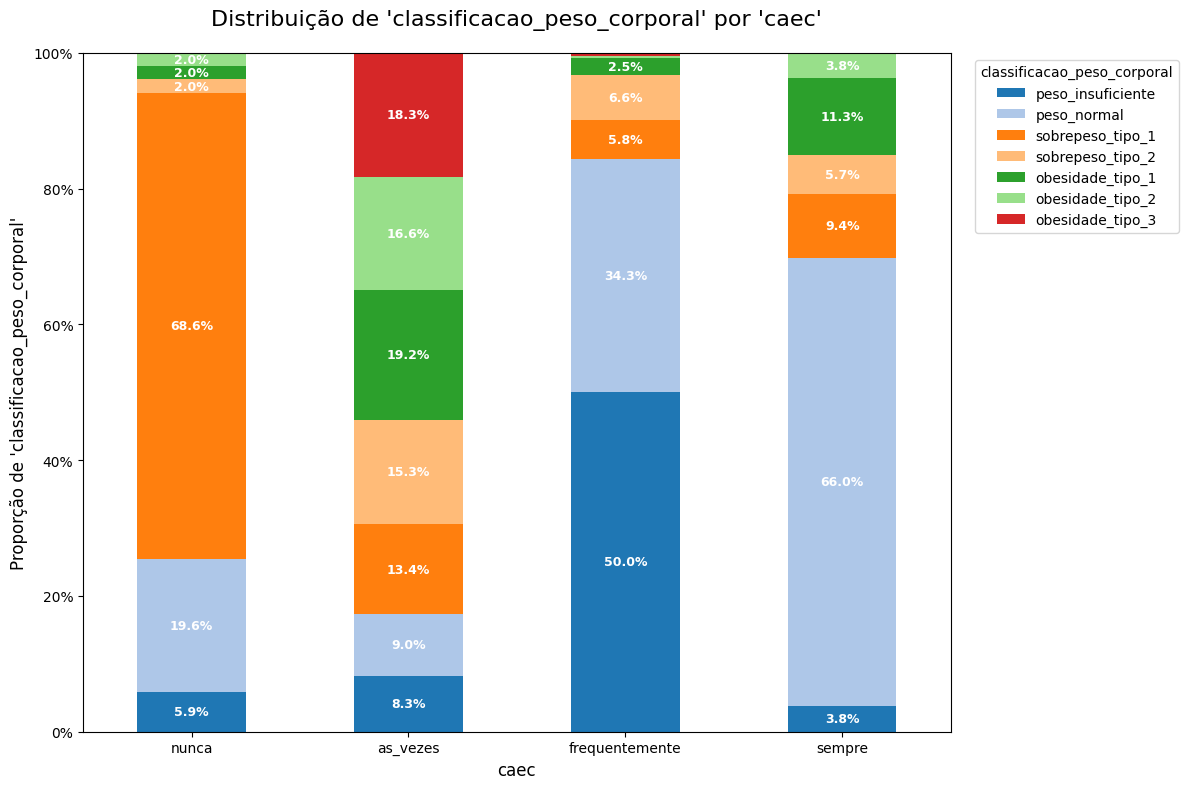

In [425]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'caec',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_linhas = ordem_frequencia,
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `caec`**

In [427]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['calc']['novo_nome']}: {dicionario_dados_nivel_obesidade['calc']['descricao']}")

Descrição da variavel calc: Com que frequencia voce bebe alcool?


**Valores únicos da variável**

In [428]:
print(f'Os valores únicos da variável {dicionario_dados_nivel_obesidade["calc"]["novo_nome"]} são: {df.calc.unique()}')

Os valores únicos da variável calc são: ['nunca' 'as_vezes' 'frequentemente' 'sempre']


**Conclusão:**

A variável calc é estatisticamente desbalanceada e possui a categoria ´sempre´ com apenas 1 registro, o que a torna rara e inviável para o treinamento.

A categoria ´frequentemente´ está na zona de perigo para ser utilizada no trenamento de aprendizado de máquina, com 70 registros.

A análise Bi-variada mostra que existe poder preditivo entre as categorias e a variavel alvo. A categoria ´frequentemente´, em ordem de grandeza, é mais proxima da categoria ´sempre, por esse motivo ´sugiro juntá-las. Outra opção seria excluir o registro.

Em qualquer um dos casos é interessante verifcar após o treinamento a relevancia da feature e da avaliacao do teste A/B




**Sugestão para a feature `caec`:**

- Manter a variável juntando as categorias frequentemente e sempre.

- Utilizar a técnica `OrdinalEncoder`.

- Verificar a importância da feature.

- Teste A/B comparando os scores na validação cruzada

- Caso a importância da feature  e o teste A/B voltem sem relevância, ou indicando overfitting, retirar a mesma do treinamento.



**Análise univariada**

**Tabela de Frequência**

In [433]:
tab_freq_classificacao_calc = criar_dataframe_frequencia(df = df, coluna = 'calc', ordem_categorias = ordem_frequencia)
display(tab_freq_classificacao_calc)

,categoria,quantidade,porcentagem
0,nunca,639,30.27
1,as_vezes,1401,66.37
2,frequentemente,70,3.32
3,sempre,1,0.05


**Gráfico de barras**

/tmp/ipython-input-2076254308.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)


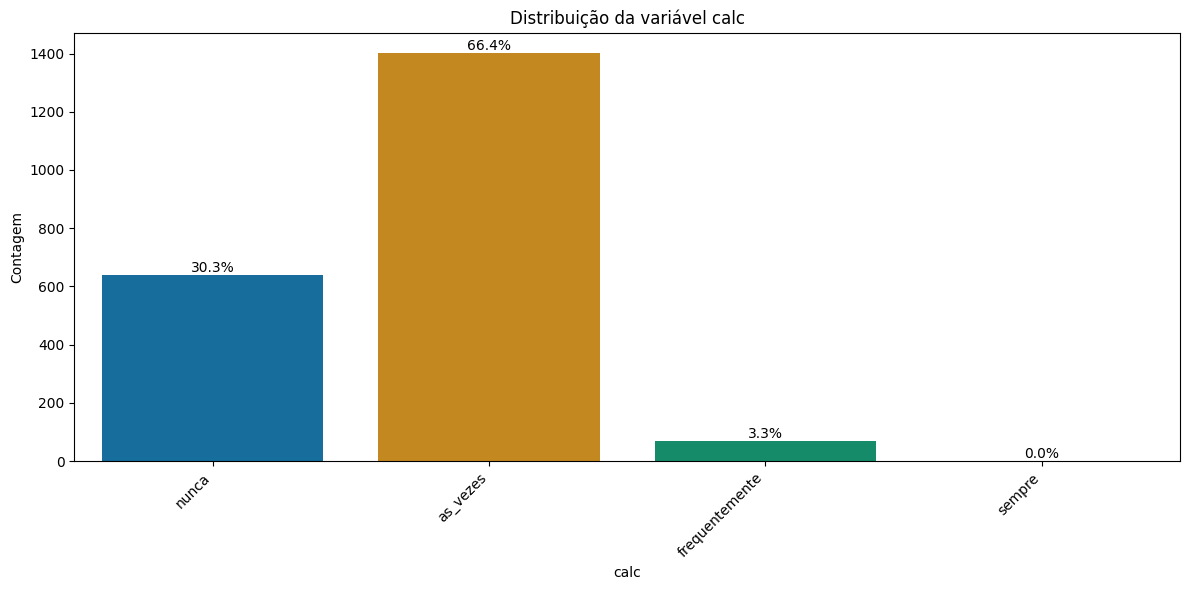

In [434]:
gera_grafico_barras(df = df , x_col = 'calc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['calc']['novo_nome']}", order = ordem_frequencia)

***Teste de aderência (univariado)***

In [435]:
frequencias_observadas_calc = tab_freq_classificacao_calc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_calc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 2391.1753
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(2391.175272382757), np.float64(0.0))

**Análise Bi-variada**

`calc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'calc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 338.5775
P-valor (p-value): 5.287e-61
Graus de Liberdade (dof): 18


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de linhas (eixo X) aplicada: ['nunca', 'as_vezes', 'frequentemente', 'sempre']
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
calc,,,,,,,
nunca,18.31,16.74,7.82,20.03,25.82,11.11,0.16
as_vezes,10.99,11.49,15.99,10.21,12.28,15.99,23.05
frequentemente,1.43,25.71,22.86,27.14,20.00,2.86,0.00
sempre,0.00,100.00,0.00,0.00,0.00,0.00,0.00


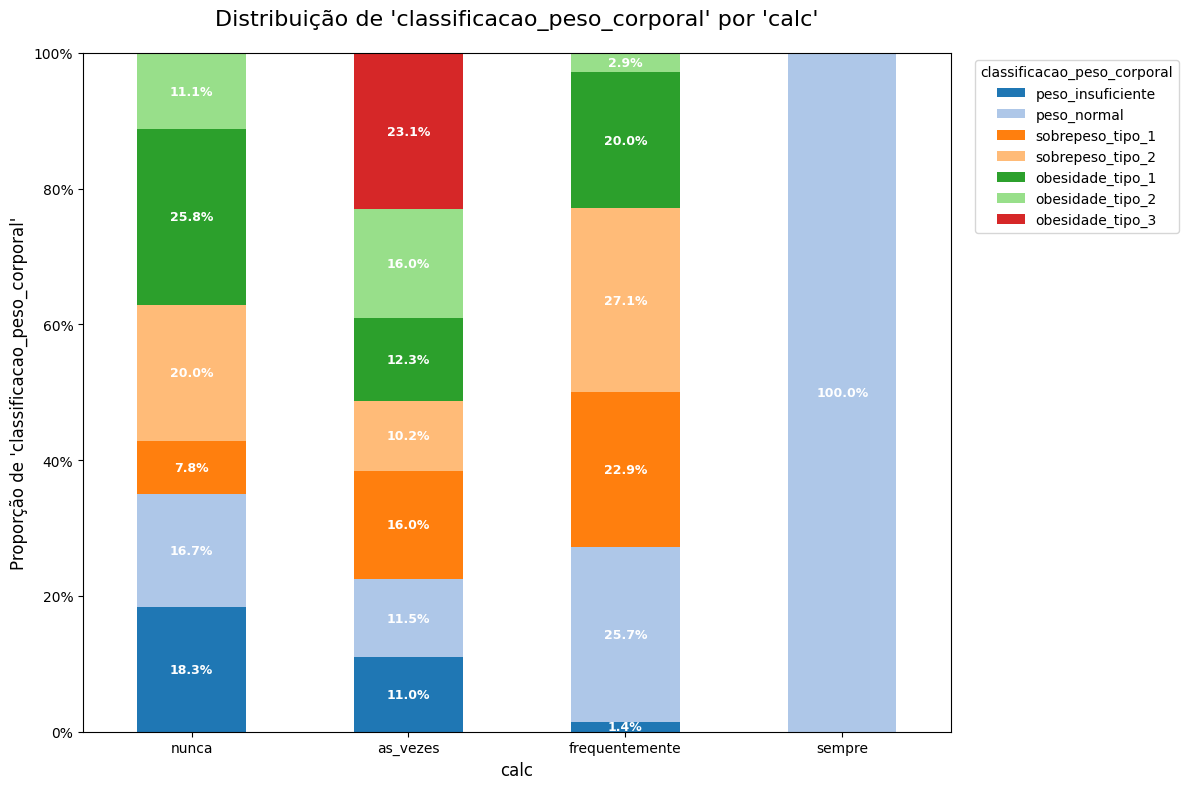

In [436]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'calc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_linhas = ordem_frequencia,
    ordem_colunas = ordem_classificao_peso_corporal
)

# **Engenharia de Features**

## **Transformações**

### **Transformação das Variáveis de String para inteiro**

Alteração das variáveis  `['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc']` para inteiro.

  -Estamos usando a função `codificar_coluna_categorica`para realizar a alteração e fazer a atualização no dicionário de dados.

  -Usamos o arquivo `transformacao_categorica_obesidade.json` como padrão para as transformações.






In [426]:
transformacoes_categoricas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/transformacao_categorica_obesidade.json')
colunas_para_codificar = ['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc','calc']

for coluna in colunas_para_codificar:
    codificar_coluna_categorica(df, coluna, transformacoes_categoricas, dicionario_dados_nivel_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/transformacao_categorica_obesidade.json
Valores únicos e contagem antes da codificação para a coluna 'genero':


,count
genero,
Male,1068
Female,1043


Ocorreu um erro ao codificar a coluna 'genero': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'historico_familiar':


,count
historico_familiar,
yes,1726
no,385


Ocorreu um erro ao codificar a coluna 'historico_familiar': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'favc':


,count
favc,
yes,1866
no,245


Ocorreu um erro ao codificar a coluna 'favc': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'caec':


,count
caec,
as_vezes,1765
frequentemente,242
sempre,53
nunca,51


Ocorreu um erro ao codificar a coluna 'caec': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'fumante':


,count
fumante,
no,2067
yes,44


Ocorreu um erro ao codificar a coluna 'fumante': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'scc':


,count
scc,
no,2015
yes,96


Ocorreu um erro ao codificar a coluna 'scc': 'valores_originais'
Valores únicos e contagem antes da codificação para a coluna 'calc':


,count
calc,
as_vezes,1401
nunca,639
frequentemente,70
sempre,1


Ocorreu um erro ao codificar a coluna 'calc': 'valores_originais'


## **Transformação de dados**

In [ ]:
display(HTML(df.head().to_html(index = False)))

**Análise:**

- As varíaveis `(genero, historico_familiar, favc, fumante, scc)` já foram codificadas de forma binária e não precisam de outra padronização em princípio para este problema de padronização multiclasse que estamos resolvendo.

- Variáveis `(CAEC, CALC)` possuem múltiplas categorias e sofreram já uma codificação ordinal. No entanto, para modelos sensíveis a escala é recomendado a padronização mesmo que o ganho seja pequeno.

- Variavel `mtrans` 's uma categria nominal sem ordem, com isso não faz sentido a transformação para números inteiros faz mais sentido utilizar a técnica de `one-hot-encoding`.

- As variáveis `(idade, altura, peso, imc)` não passaram por nenhum tipo de padronização e será utilizado o processo de `StandardScaler` para deixá-las em um intervalo entre 0 e 1.

- As variáveis `ch20, faf, tue` parecem ter passado por algum processo de padronizaçaò , mais será utilizado novamente o processo de `StandardScaler` para deixá-las em um intervalo entre 0 e 1.

- A variável alvo `classificacao_peso_corporal`é categórica com uma ordem clara de magnitude, por isso vamos aplicar o processo de `Label Encoding`

- A variável `classificacao_imc` foi criada para compará-la a variável classficiacao corporal.

Nome dataframe atualizado após pré processamento

In [ ]:
df.describe()

In [ ]:
# Selecionar apenas colunas numéricas
df_numerico = df.select_dtypes(include=['float64', 'int64'])

print("Estatísticas Descritivas das Colunas Numéricas:")
display(df_numerico.describe())

print("\nVisualização das Distribuições das Colunas Numéricas (Histograms):")

# Gerar histogramas para cada coluna numérica
num_cols = len(df_numerico.columns)
num_rows = (num_cols + 2) // 3

plt.figure(figsize=(15, num_rows * 5))

for i, col in enumerate(df_numerico.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.histplot(data=df_numerico, x=col, kde=True)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()



### **Padronização de Variáveis Numéricas com `StandardScaler`**



Dataframe criado com os dados processados: `df_processado`

In [ ]:
colunas_para_padronizar = ['idade', 'altura', 'peso', 'ch20', 'imc', 'ncp', 'faf', 'tue', 'caec', 'calc']
df_processado = padronizar_colunas_standardscaler(df, colunas_para_padronizar = colunas_para_padronizar , dicionario = dicionario_dados_nivel_obesidade, nome_novo_df= 'df_processado')

In [ ]:
display(df_processado.head(5))

### **Aplicação de `one_hot_encoding` na variável `mtrans`**

In [ ]:
colunas = ['mtrans']
df_processado = aplicar_one_hot_encoding(df_processado, colunas_para_ohe = colunas, dicionario = dicionario_dados_nivel_obesidade)


### **Aplicação de `OrdinalEnconder` na variável alvo `classificacao_peso_corporal`**

In [ ]:

ordem_classificao_peso_corporal = [
    'peso_insuficiente',
    'peso_normal',
    'sobrepeso_tipo_1',
    'sobrepeso_tipo_2',
    'obesidade_tipo_1',
    'obesidade_tipo_2',
    'obesidade_tipo_3'
]

In [ ]:
df_processado = aplicar_ordinal_encoding(df=df_processado, coluna='classificacao_peso_corporal', ordem_categorias=ordem_classificao_peso_corporal, dicionario=dicionario_dados_nivel_obesidade) # Pass the variable, not the string

# **Geracao de arquivos transformados**

## **Arquivo CSV após transformção**

In [ ]:
criar_csv_de_dataframe(df_processado, 'obesidade_processado.csv')

## **Arquivo de dicionário de dados**

In [ ]:
criar_json_de_dicionario(dicionario_dados_nivel_obesidade, 'dicionario_dados_tech_challenge_4.json')